# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data** so that it is accepted by Keras


## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [1]:
import os
import warnings

import numpy

warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA/MPS is available (for GPU usage)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [3]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    
    
    df['z-axis'] = pd.to_numeric(df['z-axis'], errors='coerce')
    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    # Transform 'z-axis' column to float
    # df['z-axis'] = df['z-axis'].apply(convert_to_float)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

1.   List item
2.   List item

Then 'file_path' the directory to where you have put the data.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

file_path = '../data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [5]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


user activity       timestamp  x-axis  y-axis  z-axis
0    33  Jogging  49105962326000    -0.7    12.7     0.5
1    33  Jogging  49106062271000     5.0    11.3     1.0
2    33  Jogging  49106112167000     4.9    10.9    -0.1
3    33  Jogging  49106222305000    -0.6    18.5     3.0
4    33  Jogging  49106332290000    -1.2    12.1     7.2
5    33  Jogging  49106442306000     1.4    -2.5    -6.5
6    33  Jogging  49106542312000    -0.6    10.6     5.7
7    33  Jogging  49106652389000    -0.5    13.9     7.1
8    33  Jogging  49106762313000    -8.4    11.4     5.1
9    33  Jogging  49106872299000     1.0     1.4     1.6

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098208 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098208 non-null  int64  
 1   activity   1098208 non-null  object 
 2   timestamp  1098208 non-null  int64  
 3   x-axis     1098208 non-null  float64
 4   y-axis     1098208 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


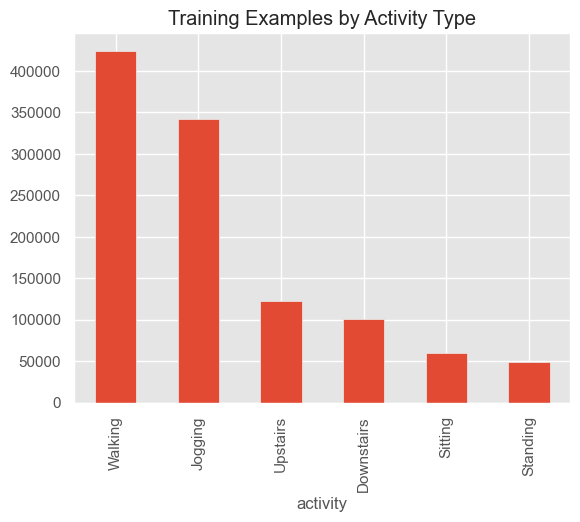

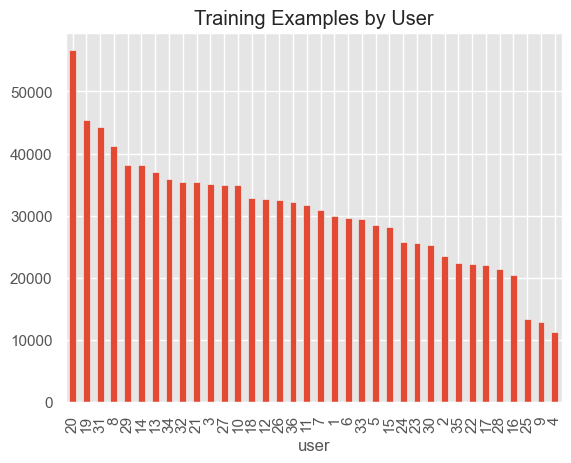

In [7]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

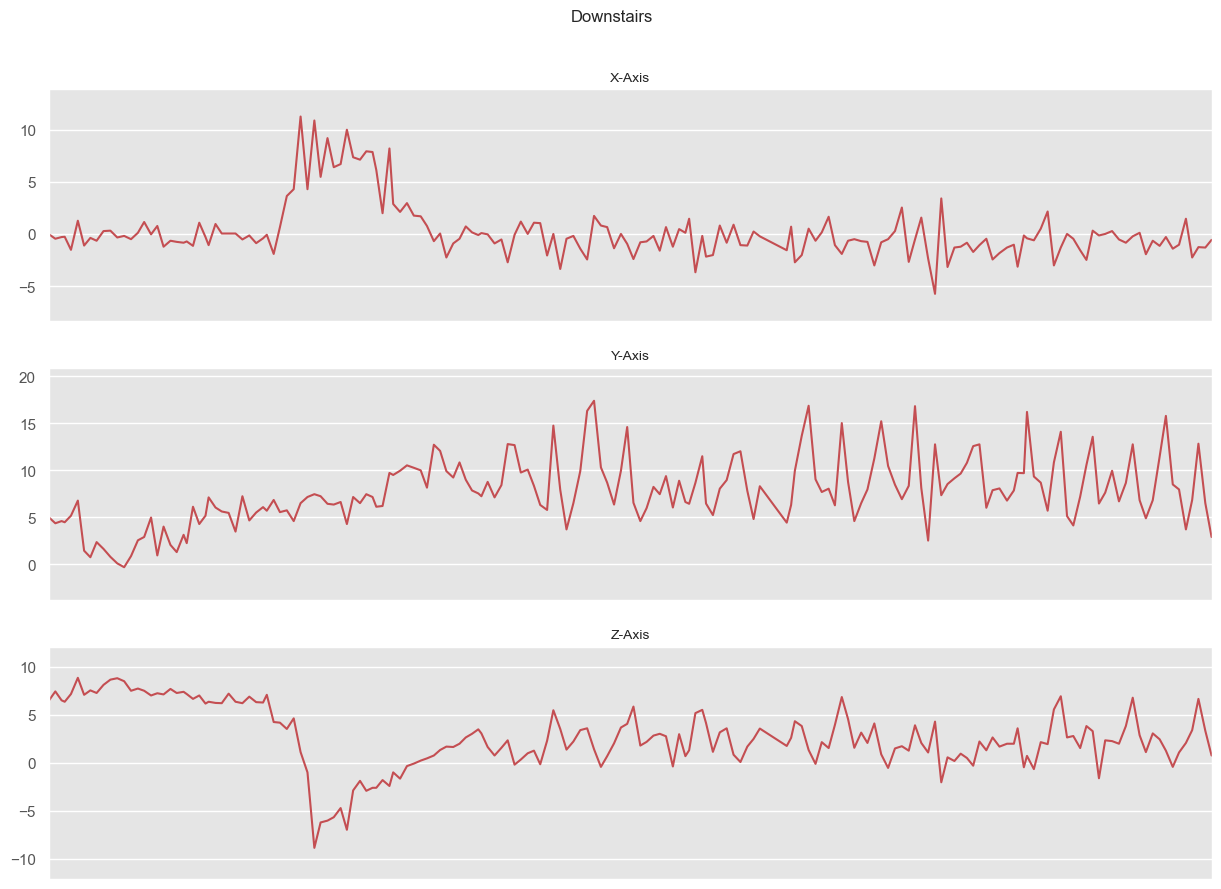

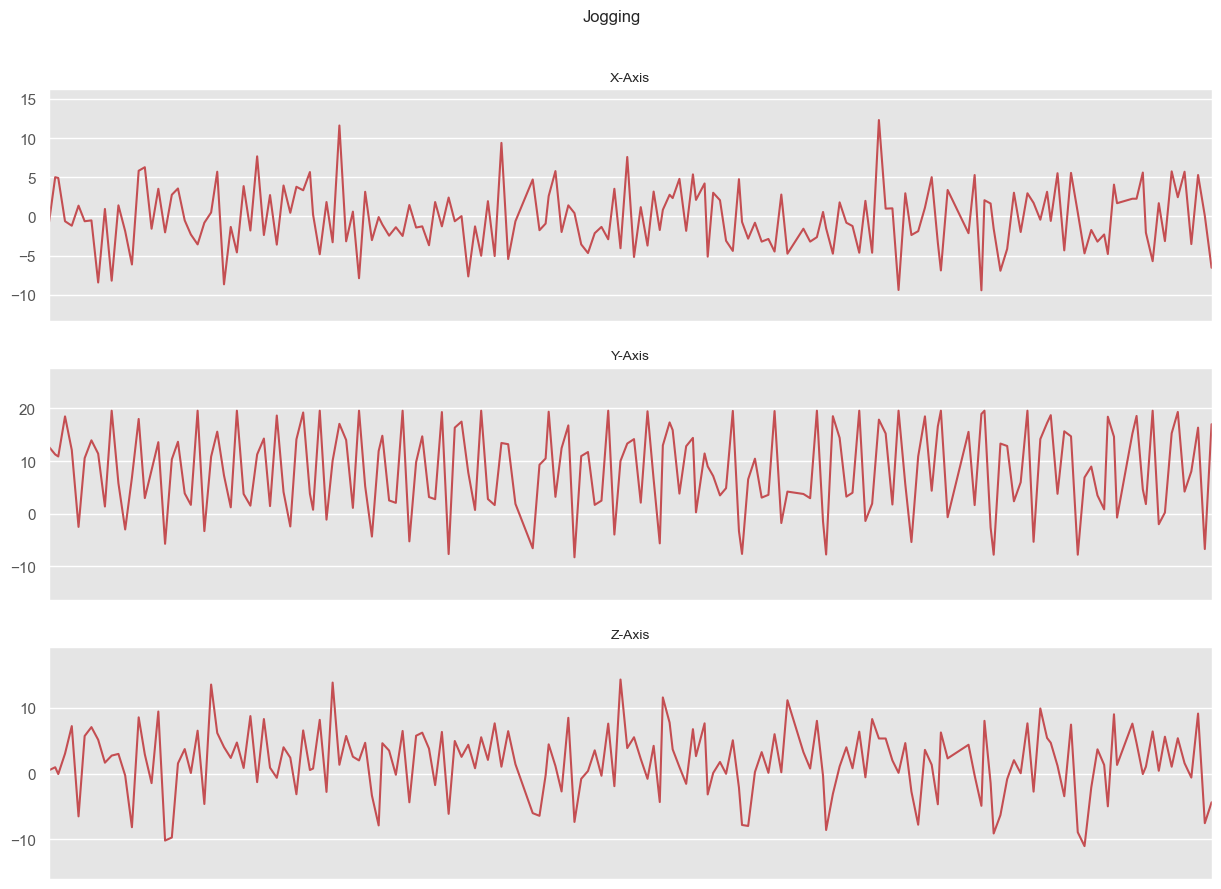

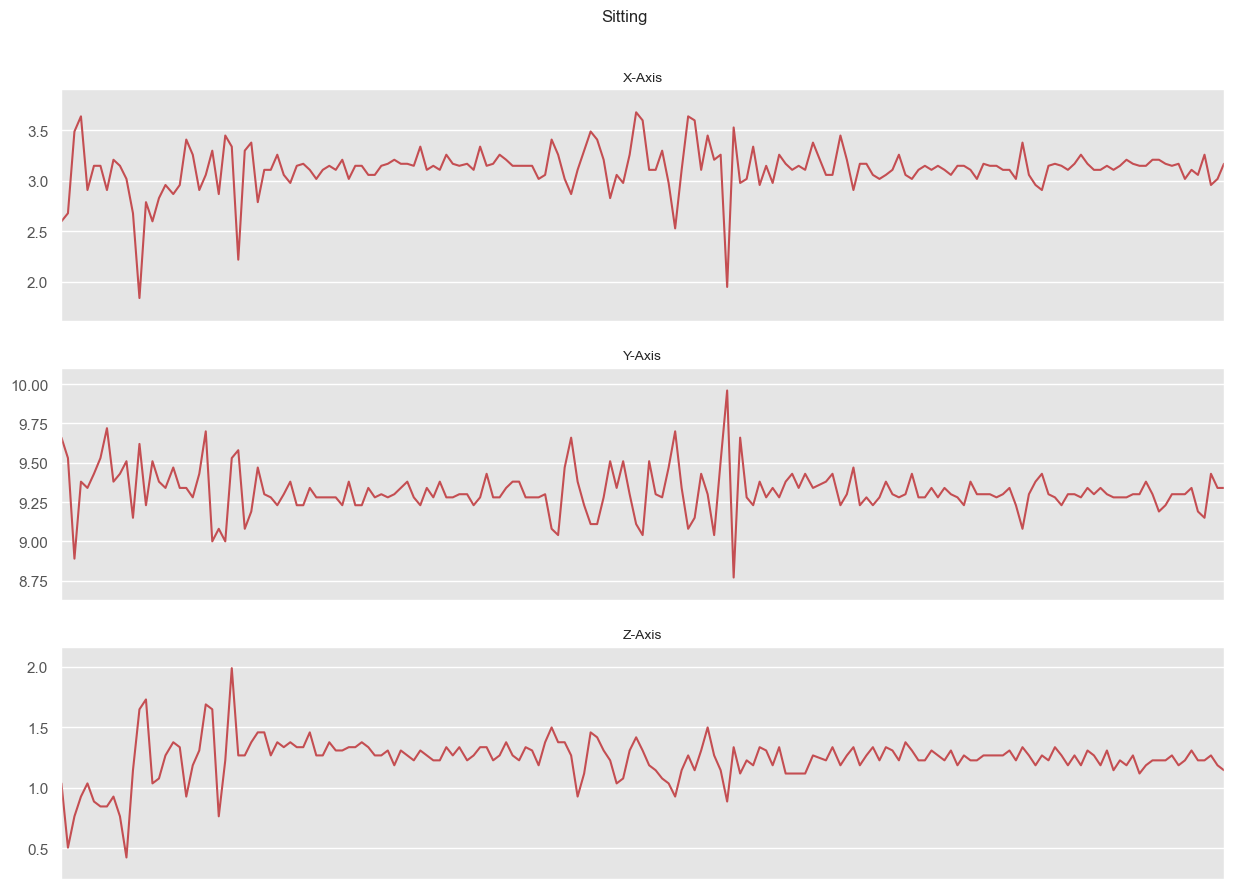

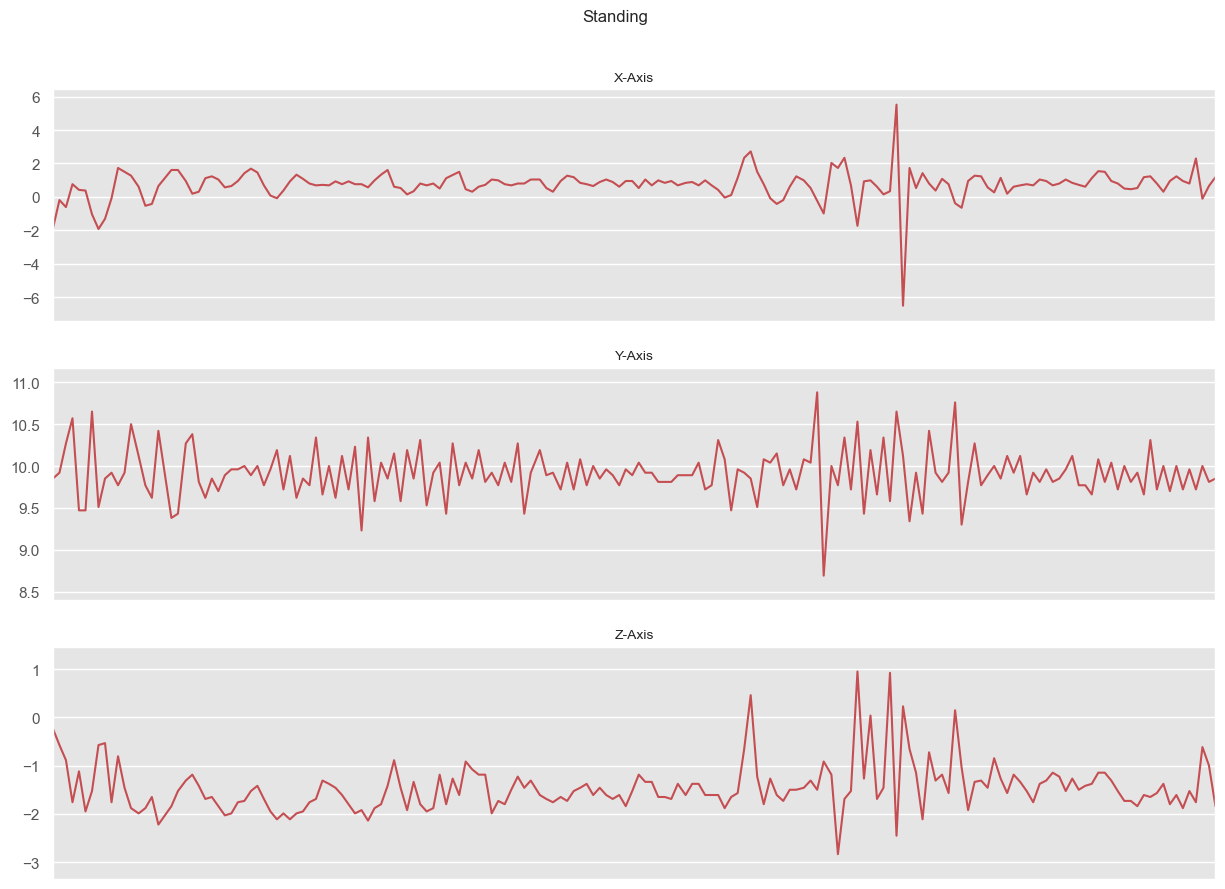

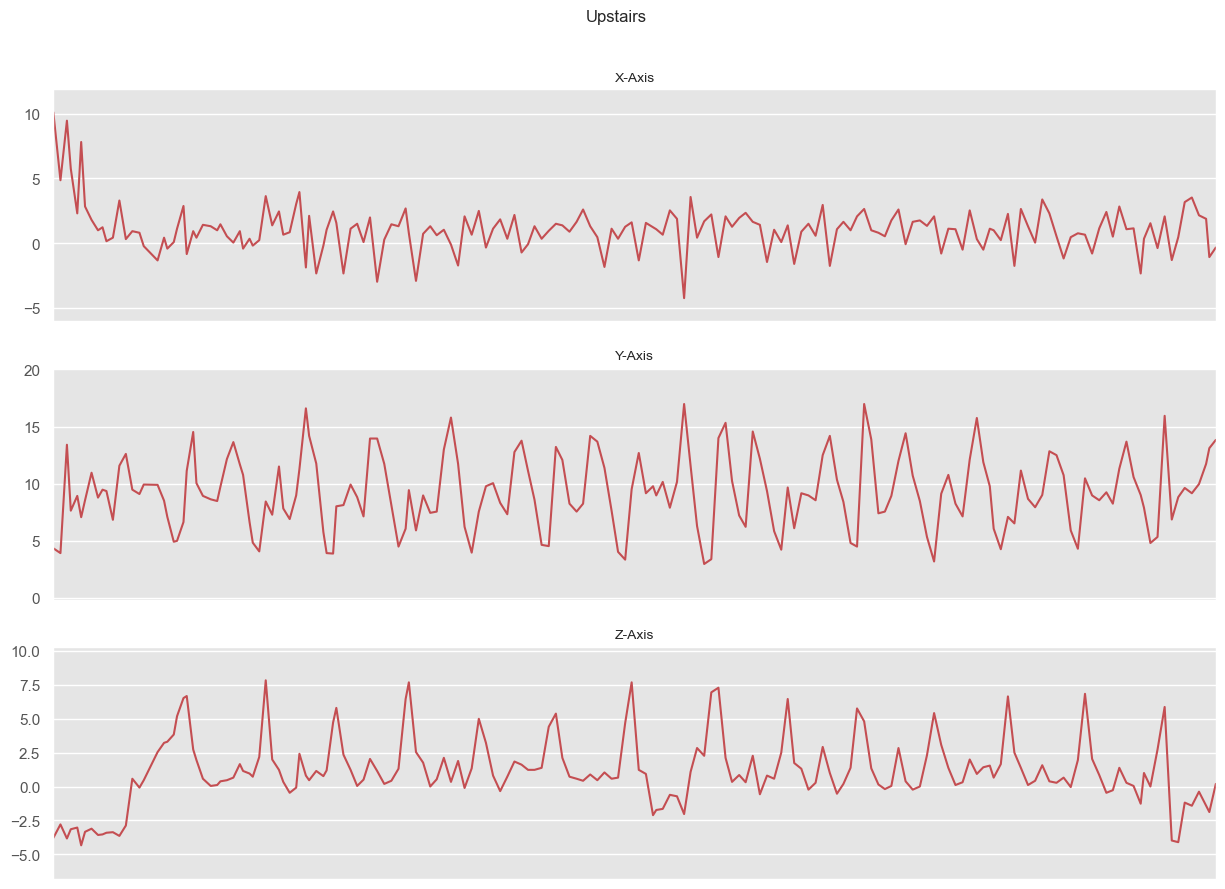

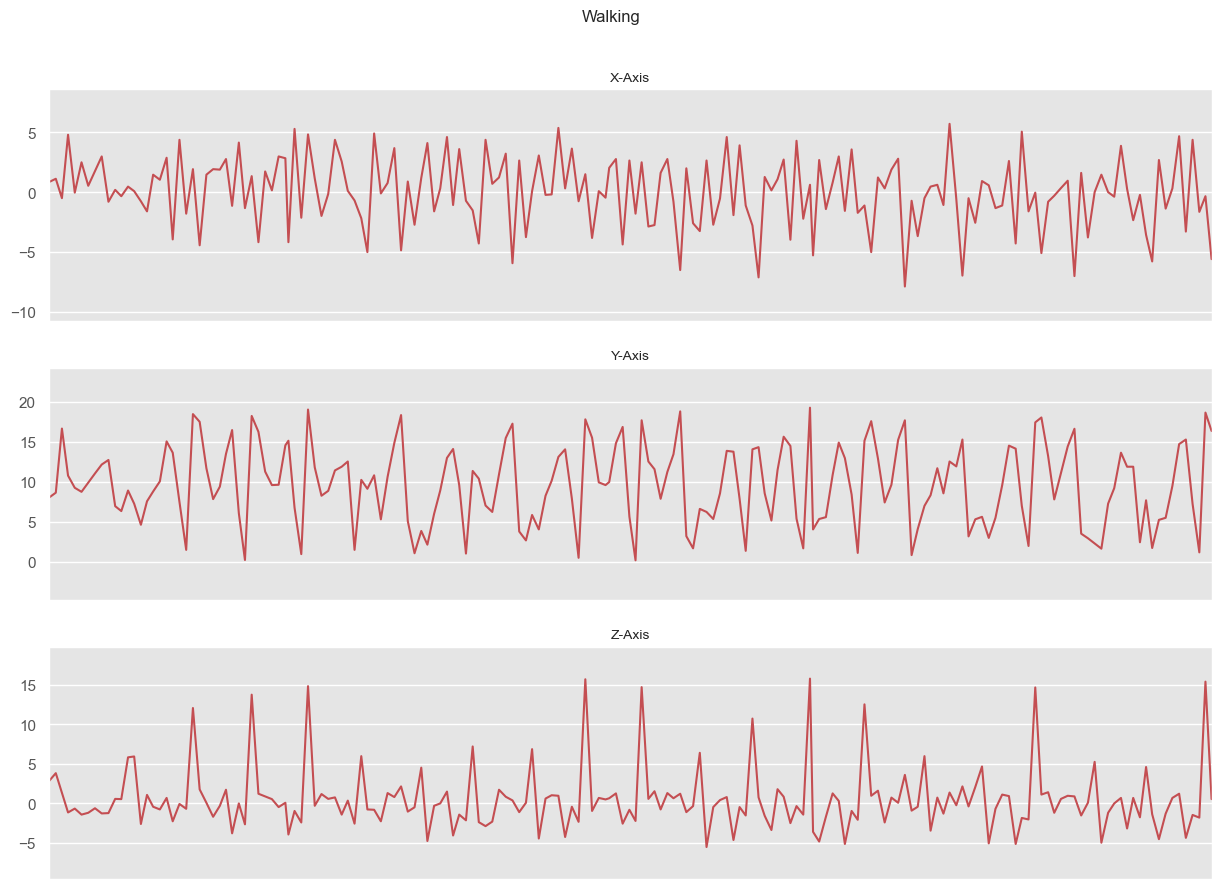

In [8]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')  # x
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')  # y
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [9]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

user activity       timestamp  x-axis  y-axis  z-axis  ActivityEncoded
0    33  Jogging  49105962326000    -0.7    12.7     0.5                1
1    33  Jogging  49106062271000     5.0    11.3     1.0                1
2    33  Jogging  49106112167000     4.9    10.9    -0.1                1
3    33  Jogging  49106222305000    -0.6    18.5     3.0                1
4    33  Jogging  49106332290000    -1.2    12.1     7.2                1

In [10]:
# Split data into train and test set
# train/validation: user 1 ~ 28
# test: user 28 ~

from sklearn.model_selection import train_test_split

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([32,31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

print(df_train.shape)
print(df_validate.shape)
print(df_test.shape)

(834784, 7)
(143368, 7)
(120056, 7)


In [11]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

df_train.head()

user activity       timestamp  x-axis  y-axis  z-axis  ActivityEncoded
8489    17  Walking  57869902574000     0.0     0.5    -0.0                5
8490    17  Walking  57870012316000    -0.0     0.5    -0.0                5
8491    17  Walking  57870122301000    -0.0     0.5    -0.0                5
8492    17  Walking  57870222246000     0.0     0.5    -0.0                5
8493    17  Walking  57870332292000     0.0     0.5    -0.0                5

Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshpae it.

In [12]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [13]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [14]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

print('x_validate shape: ', x_validate.shape)
print(x_validate.shape[0], 'validation samples')
print('y_validate shape: ', y_validate.shape)

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
x_validate shape:  (3583, 80, 3)
3583 validation samples
y_validate shape:  (3583,)
x_test shape:  (3000, 80, 3)
3000 test samples
y_test shape:  (3000,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [15]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [16]:
input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('x_validate shape:', x_validate.shape)
print('x_test shape:', x_test.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
x_validate shape: (3583, 240)
x_test shape: (3000, 240)
input shape: 240


In [17]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [18]:
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


In PyTorch, we need to wrap these NumPy arrays into a dataset and then create a DataLoader for batch processing.

In [19]:
# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron

## Base MLP

In [51]:
# Create DataLoaders
batch_size = 200  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MyMLP(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyMLP, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_base = MyMLP(TIME_PERIODS, n_classes)

model_mlp_base.to(device)

# Print model summary
print(model_mlp_base)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp_base.parameters(), lr=0.001)

EPOCHS = 500

train_losses_base = []
val_losses_base = []
train_accs_base = []
val_accs_base = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_base.append(train_loss)
    train_accs_base.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_base.append(test_loss)
    val_accs_base.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_mlp_base, device, train_loader, my_optimizer, epoch)
    validate(model_mlp_base, device, validate_loader)
    early_stopping(val_losses_base[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
# for epoch in range(1, EPOCHS + 1):
#     train(model_mlp_base, device, train_loader, my_optimizer, epoch)
#     validate(model_mlp_base, device, validate_loader)

MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.005508 	Accuracy: 62.39%
Validation: Average loss: 0.0057, Accuracy: 2213/3583 (61.76%)
Train Epoch: 2 	Loss: 0.003345 	Accuracy: 76.58%
Validation: Average loss: 0.0048, Accuracy: 2279/3583 (63.61%)
Train Epoch: 3 	Loss: 0.002580 	Accuracy: 81.40%
Validation: Average loss: 0.0041, Accuracy: 2496/3583 (69.66%)
Train Epoch: 4 	Loss: 0.001902 	Accuracy: 85.34%
Validation: Average loss: 0.0041, Accuracy: 2621/3583 (73.15%)
Train Epoch: 5 	Loss: 0.001581 	Accuracy: 87.64%
Validation: Average loss: 0.0054, Accuracy: 2594/3583 (72.40%)
Train Epoch: 6 	Loss: 0.001380 	Accuracy: 88.91%
Validation: Average loss: 0.0050, Accuracy: 2614/3583 (72.96%)
Train Epoch: 7 	Loss: 0.001

Accuracy on dev set:  80.8261233603126
Loss on dev set:  0.008732044527812524


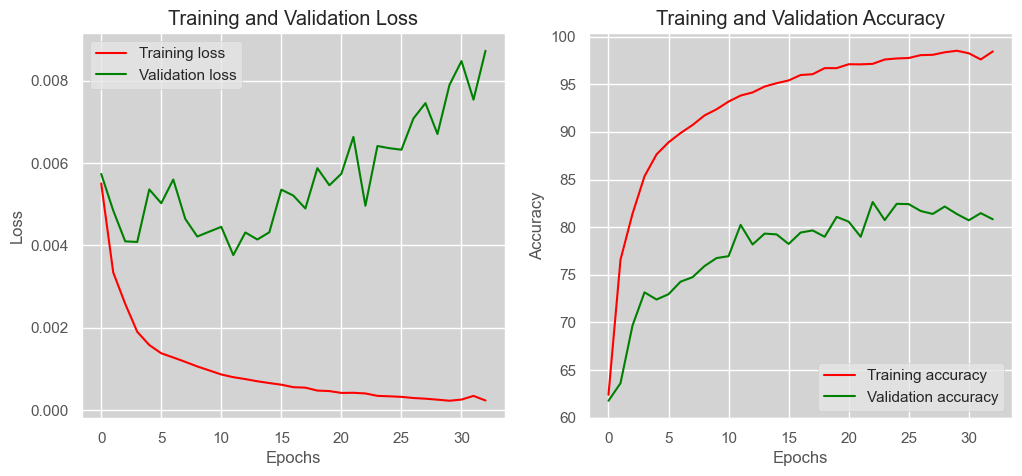

In [53]:
# Losses and accuracy plots
def plot_performance(train_losses_base, val_losses_base, train_accs_base, val_accs_base):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses_base, label='Training loss', color='red')
    plt.plot(val_losses_base, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs_base, label='Training accuracy', color='red')
    plt.plot(val_accs_base, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()

print('Accuracy on dev set: ', val_accs_base[-1])
print('Loss on dev set: ', val_losses_base[-1])

plot_performance(train_losses_base, val_losses_base, train_accs_base, val_accs_base)

Result from the article

![Expectation](attachment:16797bb4-c2ae-4f1b-8a7a-e195e39da9c3.png)

## Configuration 1: Increase the Number of Hidden Layers and Neurons

In [61]:
# Create DataLoaders
batch_size = 200  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
class MyMLP_Configuration_1(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyMLP_Configuration_1, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        self.flatten = nn.Flatten()
        # Adjusted the number of neurons in the layers
        self.fc1 = nn.Linear(time_periods * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_config1 = MyMLP_Configuration_1(TIME_PERIODS, n_classes)

model_mlp_config1.to(device)

# Print model summary
print(model_mlp_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp_config1.parameters(), lr=0.001)

EPOCHS = 500

train_losses_config1 = []
val_losses_config1 = []
train_accs_config1 = []
val_accs_config1 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_config1.append(train_loss)
    train_accs_config1.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_config1.append(test_loss)
    val_accs_config1.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_mlp_config1, device, train_loader, my_optimizer, epoch)
    validate(model_mlp_config1, device, validate_loader)
    early_stopping(val_losses_config1[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# for epoch in range(1, EPOCHS + 1):
#     train(model_mlp, device, train_loader, my_optimizer, epoch)
#     validate(model_mlp, device, validate_loader)

MyMLP_Configuration_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.005632 	Accuracy: 59.03%
Validation: Average loss: 0.0059, Accuracy: 2205/3583 (61.54%)
Train Epoch: 2 	Loss: 0.003228 	Accuracy: 77.10%
Validation: Average loss: 0.0037, Accuracy: 2540/3583 (70.89%)
Train Epoch: 3 	Loss: 0.002134 	Accuracy: 84.21%
Validation: Average loss: 0.0037, Accuracy: 2531/3583 (70.64%)
Train Epoch: 4 	Loss: 0.001665 	Accuracy: 87.31%
Validation: Average loss: 0.0044, Accuracy: 2621/3583 (73.15%)
Train Epoch: 5 	Loss: 0.001390 	Accuracy: 89.50%
Validation: Average loss: 0.0046, Accuracy: 2703/3583 (75.44%)
Tra

Accuracy on dev set:  79.09572983533351
Loss on dev set:  0.011410940559424926


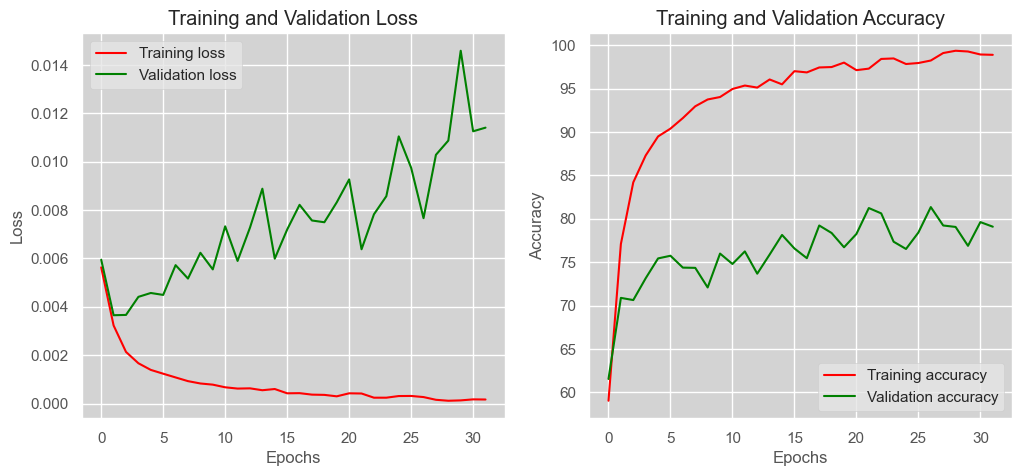

In [79]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()

print('Accuracy on dev set: ', val_accs_config1[-1])
print('Loss on dev set: ', val_losses_config1[-1])

plot_performance(train_losses_config1, val_losses_config1, train_accs_config1, val_accs_config1)

## Configuration 2: Keeping the Number of Hidden Layers Same as Base Model but Using Leaky-Relu Activation function

In [20]:
# Create DataLoaders
batch_size = 200 # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
# Multi-layer Perceptron
class MyMLP_Configuration_2(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyMLP_Configuration_2, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, n_classes)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.flatten(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_config2 = MyMLP_Configuration_2(TIME_PERIODS, n_classes)

model_mlp_config2.to(device)

# Print model summary
print(model_mlp_config2)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp_config2.parameters(), lr=0.001)


EPOCHS = 500

train_losses_config2 = []
val_losses_config2 = []
train_accs_config2 = []
val_accs_config2 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_config2.append(train_loss)
    train_accs_config2.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_config2.append(test_loss)
    val_accs_config2.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=20, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_mlp_config2, device, train_loader, my_optimizer, epoch)
    validate(model_mlp_config2, device, validate_loader)
    early_stopping(val_losses_config2[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# for epoch in range(1, EPOCHS + 1):
#     train(model_mlp, device, train_loader, my_optimizer, epoch)
#     validate(model_mlp, device, validate_loader)

MyMLP_Configuration_2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=6, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)
Train Epoch: 1 	Loss: 0.005569 	Accuracy: 60.33%
Validation: Average loss: 0.0062, Accuracy: 2204/3583 (61.51%)
Train Epoch: 2 	Loss: 0.003277 	Accuracy: 77.30%
Validation: Average loss: 0.0045, Accuracy: 2355/3583 (65.73%)
Train Epoch: 3 	Loss: 0.002565 	Accuracy: 81.26%
Validation: Average loss: 0.0036, Accuracy: 2516/3583 (70.22%)
Train Epoch: 4 	Loss: 0.001900 	Accuracy: 85.69%
Validation: Average loss: 0.0046, Accuracy: 2509/3583 (70.03%)
Train Epoch: 5 	Loss: 0.001617 	Accuracy: 87.33%
Validation: Average loss: 0.0046, Accuracy: 2561/3583 (71.48%)
Train Epoch: 6 	Loss: 0.001449 	Accuracy: 88.71%
Validation: Average loss: 0

Accuracy on val data:  82.08205414457159
Loss on val data:  0.011295359585201692


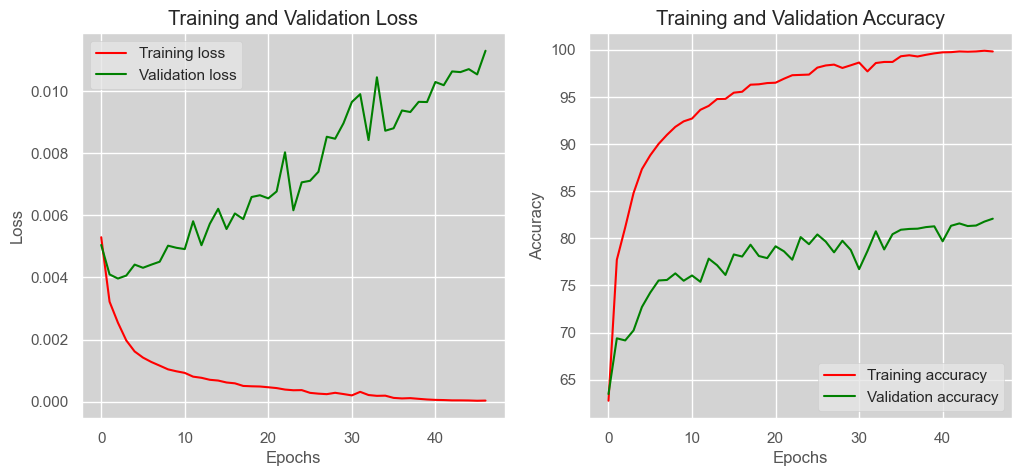

In [80]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_config2[-1])
print('Loss on val data: ', val_losses_config2[-1])

plot_performance(train_losses_config2, val_losses_config2, train_accs_config2, val_accs_config2)

## Configuration 3: Increasing the Hidden Layers and Neurons and Decreasing the Learning Rate and Batch Size

In [91]:
# Create DataLoaders
batch_size = 50  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyMLP_Configuration_3(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyMLP_Configuration_3, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        self.flatten = nn.Flatten()
        # Adjusted the number of neurons in the layers
        self.fc1 = nn.Linear(time_periods * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_config3 =  MyMLP_Configuration_3(TIME_PERIODS, n_classes)

model_mlp_config3.to(device)

# Print model summary
print(model_mlp_config3)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp_config3.parameters(), lr=0.0001)


EPOCHS = 500

train_losses_config3 = []
val_losses_config3 = []
train_accs_config3 = []
val_accs_config3 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_config3.append(train_loss)
    train_accs_config3.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_config3.append(test_loss)
    val_accs_config3.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_mlp_config3, device, train_loader, my_optimizer, epoch)
    validate(model_mlp_config3, device, validate_loader)
    early_stopping(val_losses_config3[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


MyMLP_Configuration_3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.025199 	Accuracy: 55.41%
Validation: Average loss: 0.0298, Accuracy: 2196/3583 (61.29%)
Train Epoch: 2 	Loss: 0.014962 	Accuracy: 74.38%
Validation: Average loss: 0.0237, Accuracy: 2205/3583 (61.54%)
Train Epoch: 3 	Loss: 0.013140 	Accuracy: 76.58%
Validation: Average loss: 0.0191, Accuracy: 2233/3583 (62.32%)
Train Epoch: 4 	Loss: 0.011301 	Accuracy: 79.93%
Validation: Average loss: 0.0154, Accuracy: 2523/3583 (70.42%)
Train Epoch: 5 	Loss: 0.009463 	Accuracy: 83.17%
Validation: Average loss: 0.0144, Accuracy: 2576/3583 (71.90%)
Tra

Accuracy on val data:  75.88612894222719
Loss on val data:  0.02301228430722636


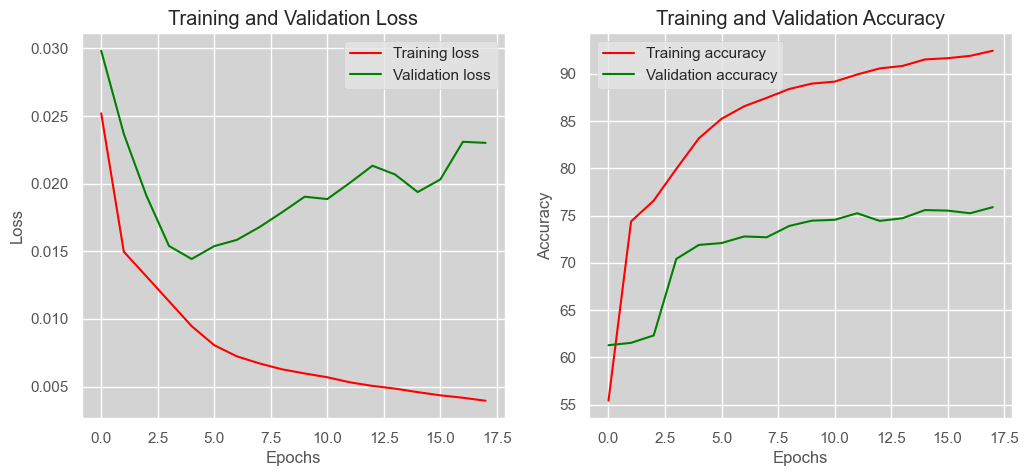

In [92]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_config3[-1])
print('Loss on val data: ', val_losses_config3[-1])

plot_performance(train_losses_config3, val_losses_config3, train_accs_config3, val_accs_config3)

## Configuration 4: Adding Hidden Layers and Neurons and Using tanh Activation Function

## Configuration 4: 

In [33]:
# Create DataLoaders
batch_size = 200 # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-layer Perceptron
# Multi-layer Perceptron
class MyMLP_Configuration_4(nn.Module):
    def __init__(self, time_periods, n_classes):
        super(MyMLP_Configuration_4, self).__init__()
        self.time_periods = time_periods
        self.n_classes = n_classes

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(time_periods * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, n_classes)
       

    def forward(self, x):
        x = self.flatten(x)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        x = F.tanh(self.fc6(x))
        x = self.fc7(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions


# Assuming TIME_PERIODS and n_classes are defined
model_mlp_config4 = MyMLP_Configuration_4(TIME_PERIODS, n_classes)

model_mlp_config4.to(device)

# Print model summary
print(model_mlp_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_mlp_config4.parameters(), lr=0.001)


EPOCHS = 500

train_losses_config4 = []
val_losses_config4 = []
train_accs_config4 = []
val_accs_config4 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_config4.append(train_loss)
    train_accs_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_config4.append(test_loss)
    val_accs_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(validate_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.01)

for epoch in range(1, EPOCHS + 1):
    train(model_mlp_config4, device, train_loader, my_optimizer, epoch)
    validate(model_mlp_config4, device, validate_loader)
    early_stopping(val_losses_config4[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# for epoch in range(1, EPOCHS + 1):
#     train(model_mlp, device, train_loader, my_optimizer, epoch)
#     validate(model_mlp, device, validate_loader)

MyMLP_Configuration_4(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=240, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.006147 	Accuracy: 55.87%
Validation: Average loss: 0.0073, Accuracy: 1675/3583 (46.75%)
Train Epoch: 2 	Loss: 0.004681 	Accuracy: 68.38%
Validation: Average loss: 0.0065, Accuracy: 2140/3583 (59.73%)
Train Epoch: 3 	Loss: 0.003874 	Accuracy: 74.31%
Validation: Average loss: 0.0064, Accuracy: 2203/3583 (61.48%)
Train Epoch: 4 	Loss: 0.003494 	Accuracy: 76.40%
Validation: Average loss: 0.0056, Accuracy: 2230/3583 (62.24%)
Train Epoch: 5 	Loss: 0.003278 	Accuracy: 77.65%
Vali

Accuracy on val data:  79.23527770025119
Loss on val data:  0.0077274887298293335


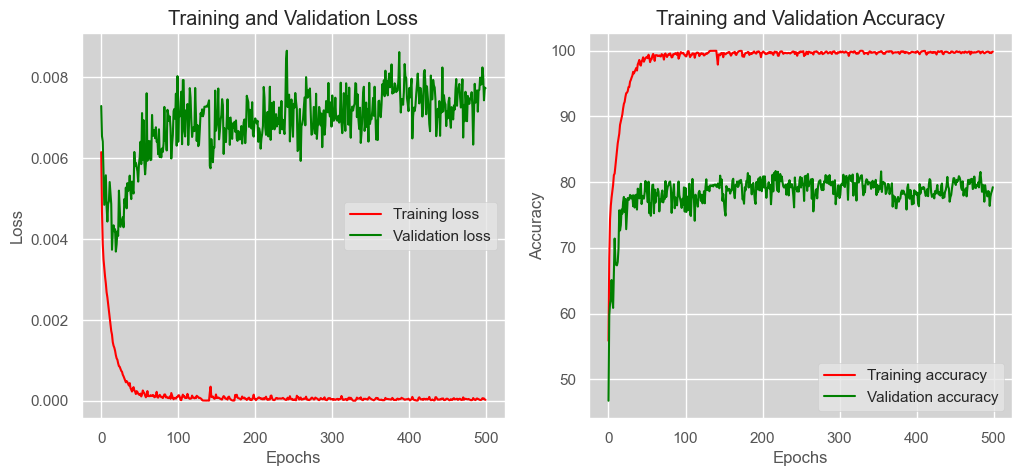

In [34]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_config4[-1])
print('Loss on val data: ', val_losses_config4[-1])

plot_performance(train_losses_config4, val_losses_config4, train_accs_config4, val_accs_config4)

[[155   0   2   0 120  11]
 [ 50 811   0   0 113  35]
 [  0   0 223   0   0   0]
 [  2   0   1 113  10  23]
 [ 61   2   6   2 190  28]
 [213  31   0   0  68 730]]


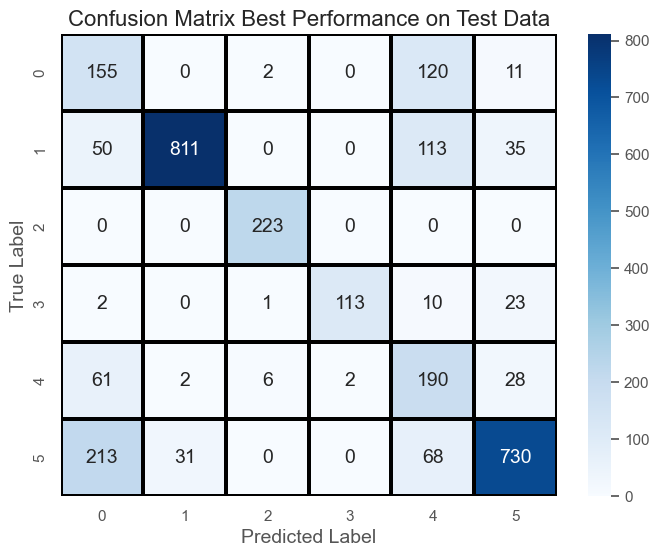

              precision    recall  f1-score   support

           0       0.32      0.54      0.40       288
           1       0.96      0.80      0.88      1009
           2       0.96      1.00      0.98       223
           3       0.98      0.76      0.86       149
           4       0.38      0.66      0.48       289
           5       0.88      0.70      0.78      1042

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.73      3000
weighted avg       0.82      0.74      0.77      3000



In [35]:
def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Best Performance on Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in test_loader:
    data = data.to(device)
    predictions = model_mlp_config2.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


## Base CNN with Early Stopping

In [36]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x = x.view(-1, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with softmax activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_base = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_base.to(device)

# Print model summary
print(model_cnn_base)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_base.parameters(), lr=0.001)

EPOCHS = 500

train_losses_base = []
val_losses_base = []
train_accs_base = []
val_accs_base = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_base.append(train_loss)
    train_accs_base.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_base.append(test_loss)
    val_accs_base.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.01)

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_base, device, train_loader, my_optimizer, epoch)
    validate(model_cnn_base, device, validate_loader)
    early_stopping(val_losses_base[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
# for epoch in range(1, EPOCHS + 1):
#     train(model_cnn, device, train_loader, my_optimizer, epoch)
#     validate(model_cnn, device, test_loader)

MyConvModel(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002263 	Accuracy: 67.32%
Validation: Average loss: 0.0036, Accuracy: 2350/3583 (65.59%)
Train Epoch: 2 	Loss: 0.001146 	Accuracy: 82.75%
Validation: Average loss: 0.0028, Accuracy: 2660/3583 (74.24%)
Train Epoch: 3 	Loss: 0.000805 	Accuracy: 87.67%
Validation: Average loss: 0.0023, Accuracy: 2731/3583 (76.22%)
Train Epoch: 4 	Loss: 0.000651 	Accuracy: 89.98%
Validation: Average loss: 0.0021, Accuracy: 2766/3583 (77.20%)
Train Epoch: 5 	Loss: 0.000593 	Accuracy: 91.01%
Validation:

Accuracy on val data:  81.88668713368685
Loss on val data:  0.005447206837303173


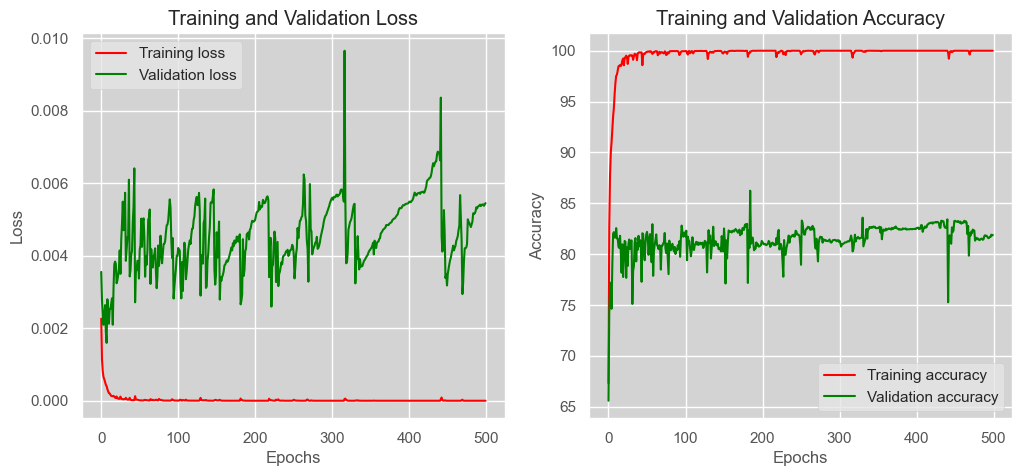

In [37]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_base[-1])
print('Loss on val data: ', val_losses_base[-1])

plot_performance(train_losses_base, val_losses_base, train_accs_base, val_accs_base)

## CNN Configuration 1: Removing 4th Conv Layer and Increasing the Kernel Size from 10 to 15

In [42]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class MyConvModel_Configuration1(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration1, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=15)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=15)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=15)
        # self.conv4 = nn.Conv1d(160, 160, kernel_size=10)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x = x.view(-1, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with softmax activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config1 = MyConvModel_Configuration1(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config1.to(device)

# Print model summary
print(model_cnn_config1)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config1.parameters(), lr=0.01)

EPOCHS = 500

train_losses_cnn_config1 = []
val_losses_cnn_config1 = []
train_accs_cnn_config1 = []
val_accs_cnn_config1 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config1.append(train_loss)
    train_accs_cnn_config1.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config1.append(test_loss)
    val_accs_cnn_config1.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config1, device, train_loader, my_optimizer, epoch)
    validate(model_cnn_config1, device, validate_loader)
    early_stopping(val_losses_cnn_config1[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
        
# for epoch in range(1, EPOCHS + 1):
#     train(model_cnn, device, train_loader, my_optimizer, epoch)
#     validate(model_cnn, device, test_loader)

MyConvModel_Configuration1(
  (conv1): Conv1d(3, 100, kernel_size=(15,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(15,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(15,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002951 	Accuracy: 60.36%
Validation: Average loss: 0.0023, Accuracy: 2572/3583 (71.78%)
Train Epoch: 2 	Loss: 0.001270 	Accuracy: 81.51%
Validation: Average loss: 0.0040, Accuracy: 2530/3583 (70.61%)
Train Epoch: 3 	Loss: 0.001021 	Accuracy: 85.44%
Validation: Average loss: 0.0033, Accuracy: 2684/3583 (74.91%)
Train Epoch: 4 	Loss: 0.000880 	Accuracy: 87.46%
Validation: Average loss: 0.0035, Accuracy: 2679/3583 (74.77%)
Train Epoch: 5 	Loss: 0.000794 	Accuracy: 89.06%
Validation: Average loss: 0.0035, Accuracy: 2706/3583 (7

Accuracy on val data:  79.62601172202065
Loss on val data:  0.0069470142164823065


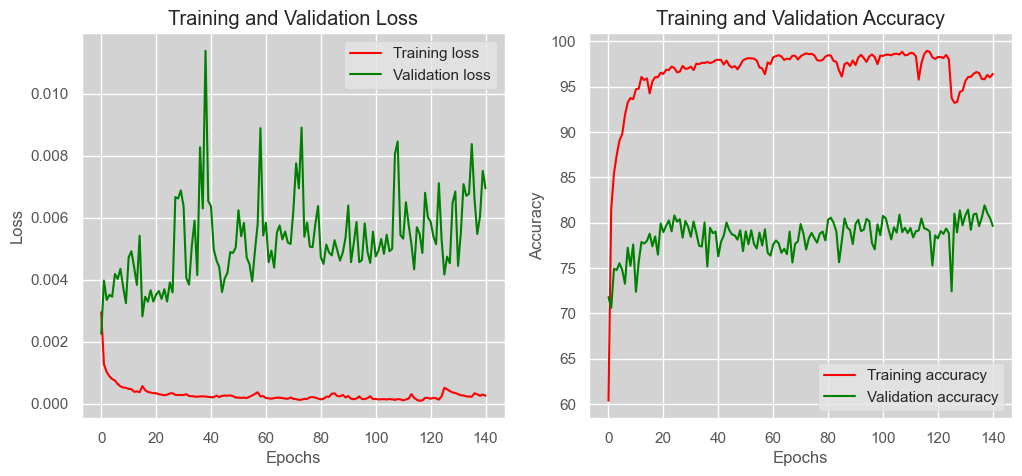

In [43]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_cnn_config1[-1])
print('Loss on val data: ', val_losses_cnn_config1[-1])

plot_performance(train_losses_cnn_config1, val_losses_cnn_config1, train_accs_cnn_config1, val_accs_cnn_config1)

## Configuration 2: Reduced Kernel Size to 3 and Increasing the Number of Hidden layers

In [48]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class MyConvModel_Configuration2(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration2, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=3)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=3)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=3)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=3)
        self.conv5 = nn.Conv1d(160, 240, kernel_size=3)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(240, n_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x = x.view(-1, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with softmax activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config2 = MyConvModel_Configuration2(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config2.to(device)

# Print model summary
print(model_cnn_config2)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config2.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config2 = []
val_losses_cnn_config2 = []
train_accs_cnn_config2 = []
val_accs_cnn_config2 = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config2.append(train_loss)
    train_accs_cnn_config2.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config2.append(test_loss)
    val_accs_cnn_config2.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.01)

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config2, device, train_loader, my_optimizer, epoch)
    validate(model_cnn_config2, device, validate_loader)
    early_stopping(val_losses_cnn_config2[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

MyConvModel_Configuration2(
  (conv1): Conv1d(3, 100, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(160, 240, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=240, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002836 	Accuracy: 56.69%
Validation: Average loss: 0.0044, Accuracy: 2015/3583 (56.24%)
Train Epoch: 2 	Loss: 0.001581 	Accuracy: 77.29%
Validation: Average loss: 0.0037, Accuracy: 2551/3583 (71.20%)
Train Epoch: 3 	Loss: 0.001095 	Accuracy: 84.10%
Validation: Average loss: 0.0038, Accuracy: 2686/3583 (74.97%)
Train Epoch: 4 	Loss: 0.000866 	Accuracy: 87.21%
Validation: Average loss: 0.0039, Accuracy: 2790/3583

Accuracy on val data:  81.77504884175272
Loss on val data:  0.006760053441371376


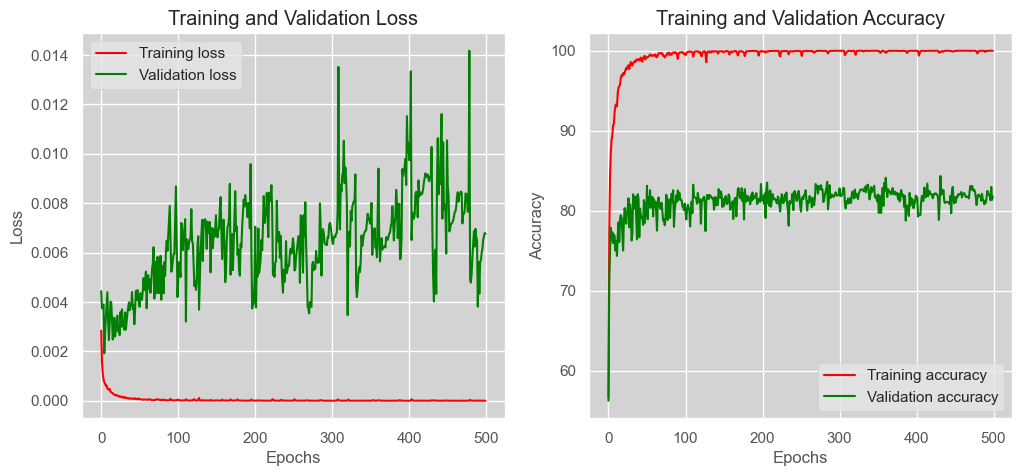

In [49]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on val data: ', val_accs_cnn_config2[-1])
print('Loss on val data: ', val_losses_cnn_config2[-1])

plot_performance(train_losses_cnn_config2, val_losses_cnn_config2, train_accs_cnn_config2, val_accs_cnn_config2)

## Configuration 3: Used 3 Convolutional Layers and just Average Pooling and Leaky Relu Activation Functions

In [75]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration3(nn.Module):    
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration3, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.avg_pool = nn.AvgPool1d(3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.01)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.01)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.01)
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config3 = MyConvModel_Configuration3(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config3.to(device)

# Print model summary
print(model_cnn_config3)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config3.parameters(), lr=0.001)


EPOCHS = 500

train_losses_cnn_config3 = []
val_losses_cnn_config3 = []
train_accs_cnn_config3 = []
val_accs_cnn_config3 = []

best_val_loss = float('inf')
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config3.append(train_loss)
    train_accs_cnn_config3.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config3.append(test_loss)
    val_accs_cnn_config3.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config3, device, train_loader, my_optimizer, epoch)
    validate(model_cnn_config3, device, validate_loader)
    early_stopping(val_losses_cnn_config3[-1])  # Pass the latest validation loss to the early stopping object
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

MyConvModel_Configuration3(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (avg_pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)


ValueError: Expected input batch_size (6800) to match target batch_size (400).

Accuracy on dev data:  81.57968183086798
Loss on dev data:  0.008275149040173155


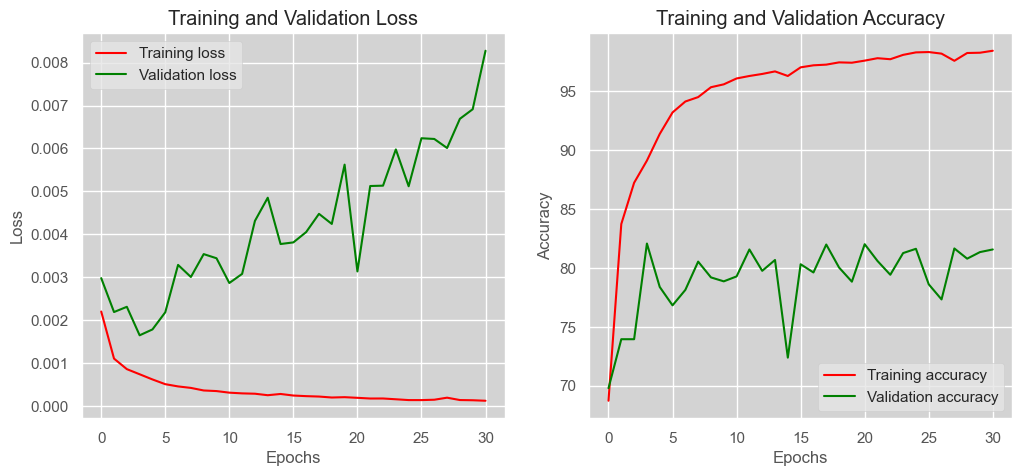

In [71]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
    
print('Accuracy on dev data: ', val_accs_cnn_config3[-1])
print('Loss on dev data: ', val_losses_cnn_config3[-1])

plot_performance(train_losses_cnn_config3, val_losses_cnn_config3, train_accs_cnn_config3, val_accs_cnn_config3)

## Configuration 4: Different Pooling and Increased Dropout

In [114]:
# Create DataLoaders
batch_size = 512  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4 = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4.to(device)

# Print model summary
print(model_cnn_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4.parameters(), lr=0.001)

BATCH_SIZE = 400
EPOCHS = 500

train_losses_cnn_config4 = []
val_losses_cnn_config4 = []
train_accs_cnn_config4 = []
val_accs_cnn_config4 = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4.append(train_loss)
    train_accs_cnn_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4.append(test_loss)
    val_accs_cnn_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.001901 	Accuracy: 66.85%
Validation: Average loss: 0.0015, Accuracy: 2170/3000 (72.33%)
Train Epoch: 2 	Loss: 0.001191 	Accuracy: 77.40%
Validation: Average loss: 0.0011, Accuracy: 2483/3000 (82.77%)
Train Epoch: 3 	Loss: 0.000941 	Accuracy: 82.32%
Validation: Average loss: 0.0010, Accuracy: 2505/3000 (83.50%)
Train Epoch: 4 	Loss: 0.000788 	Accuracy: 84.97%
Validation: Average loss: 0.0010, Accuracy: 2479/3000 (82.63%)
Train Epoch: 5 	Loss: 0.000707 	Accuracy: 86.37%
Validation: Average loss: 0.0008, Accuracy: 2566/3000 (85.53%)
Train Epoc

Accuracy on dev set:  90.13333333333334
Loss on dev set:  0.0008201109214375416


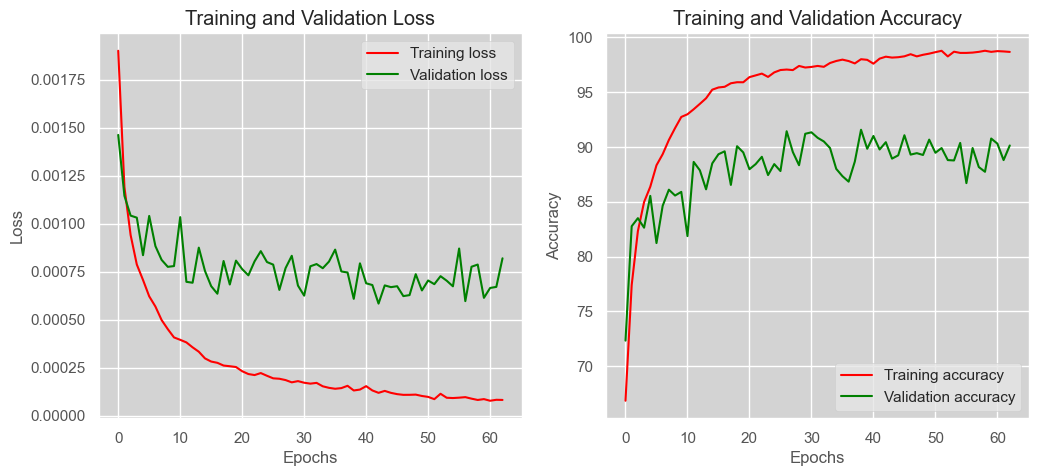

In [115]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4[-1])
print('Loss on dev set: ', val_losses_cnn_config4[-1])

plot_performance(train_losses_cnn_config4, val_losses_cnn_config4, train_accs_cnn_config4, val_accs_cnn_config4)

## Test CNN

[[ 196   34    0    0   51   81]
 [   1  975    0    0    2    0]
 [   0    0  187    0    0   39]
 [   1    0    6  208    9    1]
 [  27   53    1    0  281   75]
 [   2  313    0    0    2 1038]]


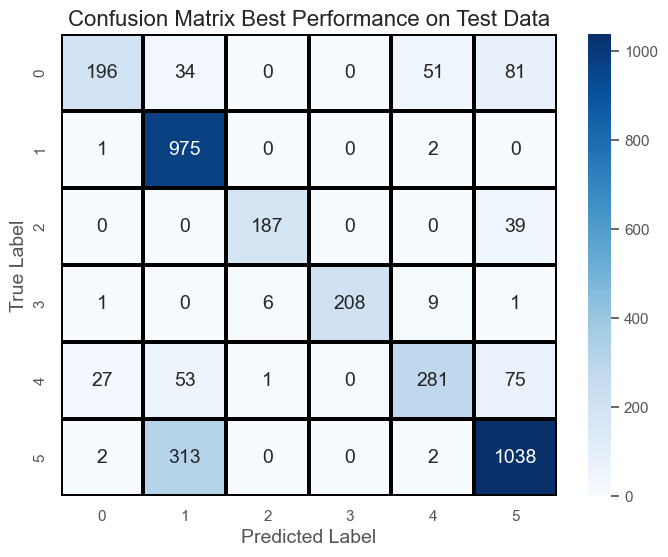

              precision    recall  f1-score   support

           0       0.86      0.54      0.67       362
           1       0.71      1.00      0.83       978
           2       0.96      0.83      0.89       226
           3       1.00      0.92      0.96       225
           4       0.81      0.64      0.72       437
           5       0.84      0.77      0.80      1355

    accuracy                           0.81      3583
   macro avg       0.87      0.78      0.81      3583
weighted avg       0.82      0.81      0.80      3583



In [161]:
def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Best Performance on Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

# 3 Reflections of the Implementation and Experimentation

## 3.1 Data Augmentation

### 3.1.a Noise Addition

In [117]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [118]:
# Apply noise addition
noise_level = 0.05
x_train_noisy = add_noise(x_train, noise_level=noise_level)
x_train_augmented = np.concatenate((x_train, x_train_noisy), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Convert your numpy arrays to PyTorch tensors
x_train_noisy_tensor = torch.tensor(x_train_augmented, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_augmented, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset_noisy = TensorDataset(x_train_noisy_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [124]:
# Create DataLoaders
# Create DataLoaders
batch_size = 512 # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoaders
batch_size = 512  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4_noisy = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4_noisy.to(device)

# Print model summary
print(model_cnn_config4_noisy)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4_noisy.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4_noisy = []
val_losses_cnn_config4_noisy = []
train_accs_cnn_config4_noisy = []
val_accs_cnn_config4_noisy = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4_noisy.append(train_loss)
    train_accs_cnn_config4_noisy.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4_noisy.append(test_loss)
    val_accs_cnn_config4_noisy.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4_noisy, device, train_loader_noisy, my_optimizer, epoch)
    if validate(model_cnn_config4_noisy, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.008305 	Accuracy: 80.79%
Validation: Average loss: 0.0008, Accuracy: 2637/3000 (87.90%)
Train Epoch: 2 	Loss: 0.004217 	Accuracy: 90.33%
Validation: Average loss: 0.0009, Accuracy: 2649/3000 (88.30%)
Train Epoch: 3 	Loss: 0.003006 	Accuracy: 93.75%
Validation: Average loss: 0.0009, Accuracy: 2674/3000 (89.13%)
Train Epoch: 4 	Loss: 0.002341 	Accuracy: 95.38%
Validation: Average loss: 0.0011, Accuracy: 2646/3000 (88.20%)
Train Epoch: 5 	Loss: 0.001937 	Accuracy: 96.22%
Validation: Average loss: 0.0009, Accuracy: 2622/3000 (87.40%)
Train Epoc

Accuracy on dev set:  91.76666666666667
Loss on dev set:  0.0010326663007338842


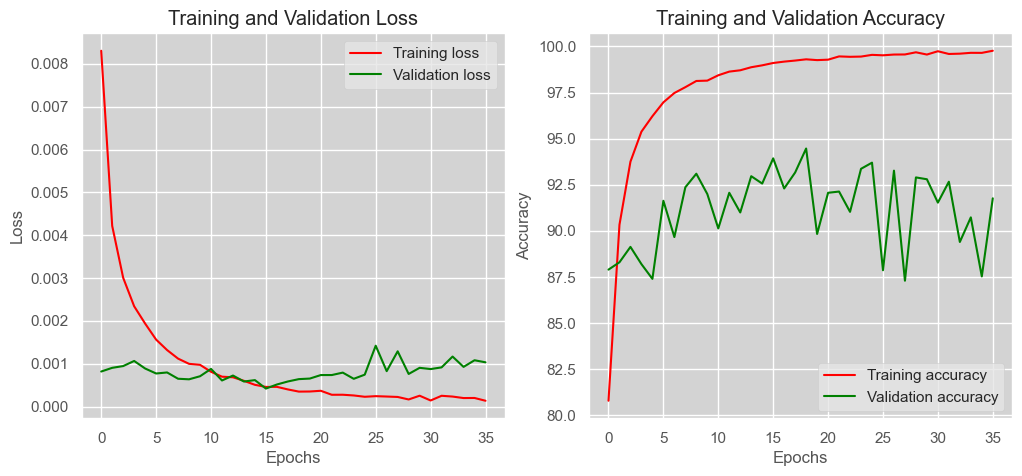

[[ 204   15    0    2   70   71]
 [   0  969    0    0    7    2]
 [   0    0  187    0    0   39]
 [   2    0   24  177   22    0]
 [  48   17    0    2  298   72]
 [   1  283    0    0    1 1070]]


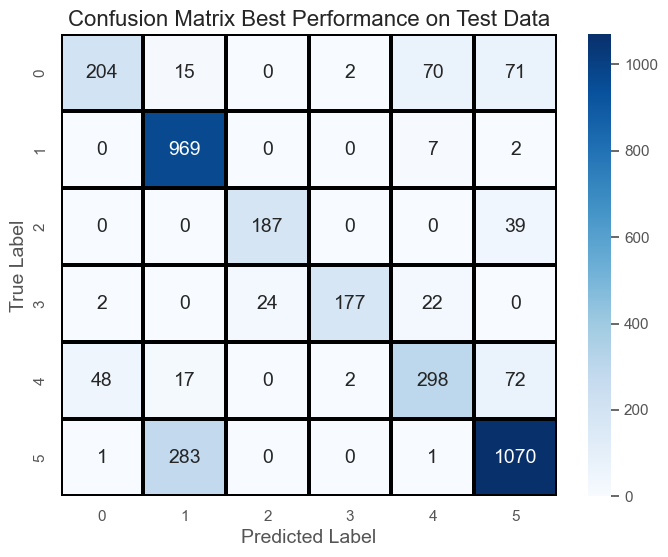

              precision    recall  f1-score   support

           0       0.80      0.56      0.66       362
           1       0.75      0.99      0.86       978
           2       0.89      0.83      0.86       226
           3       0.98      0.79      0.87       225
           4       0.75      0.68      0.71       437
           5       0.85      0.79      0.82      1355

    accuracy                           0.81      3583
   macro avg       0.84      0.77      0.80      3583
weighted avg       0.82      0.81      0.81      3583



In [160]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4_noisy[-1])
print('Loss on dev set: ', val_losses_cnn_config4_noisy[-1])

plot_performance(train_losses_cnn_config4_noisy, val_losses_cnn_config4_noisy, train_accs_cnn_config4_noisy, val_accs_cnn_config4_noisy)

def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Best Performance on Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4_noisy.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

### 3.1.b Time Shifting

In [127]:
def time_shift(data, shift_steps):
    shifted_data = np.roll(data, shift=shift_steps, axis=1)
    return shifted_data

In [136]:
# Apply time shifting
shift_steps = 30  
x_train_shifted = time_shift(x_train, shift_steps=shift_steps)

# x_train_augmented = np.concatenate((x_train, x_train_shifted), axis=0)
# y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Convert your numpy arrays to PyTorch tensors
x_train_shifted_tensor = torch.tensor(x_train_shifted, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset_shifted = TensorDataset(x_train_shifted_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_shifted = DataLoader(train_dataset_shifted, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [137]:
class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4_shifted = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4_shifted.to(device)

# Print model summary
print(model_cnn_config4_shifted)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4_shifted.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4_shifted = []
val_losses_cnn_config4_shifted = []
train_accs_cnn_config4_shifted = []
val_accs_cnn_config4_shifted = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4_shifted.append(train_loss)
    train_accs_cnn_config4_shifted.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4_shifted.append(test_loss)
    val_accs_cnn_config4_shifted.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4_shifted, device, train_loader_shifted, my_optimizer, epoch)
    if validate(model_cnn_config4_shifted, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.010172 	Accuracy: 76.73%
Validation: Average loss: 0.0095, Accuracy: 2415/3000 (80.50%)
Train Epoch: 2 	Loss: 0.006376 	Accuracy: 84.96%
Validation: Average loss: 0.0066, Accuracy: 2589/3000 (86.30%)
Train Epoch: 3 	Loss: 0.004986 	Accuracy: 88.17%
Validation: Average loss: 0.0083, Accuracy: 2490/3000 (83.00%)
Train Epoch: 4 	Loss: 0.004134 	Accuracy: 90.39%
Validation: Average loss: 0.0073, Accuracy: 2584/3000 (86.13%)
Train Epoch: 5 	Loss: 0.003460 	Accuracy: 92.16%
Validation: Average loss: 0.0094, Accuracy: 2394/3000 (79.80%)
Train Epoc

Accuracy on dev set:  91.43333333333334
Loss on dev set:  0.005195095945706536


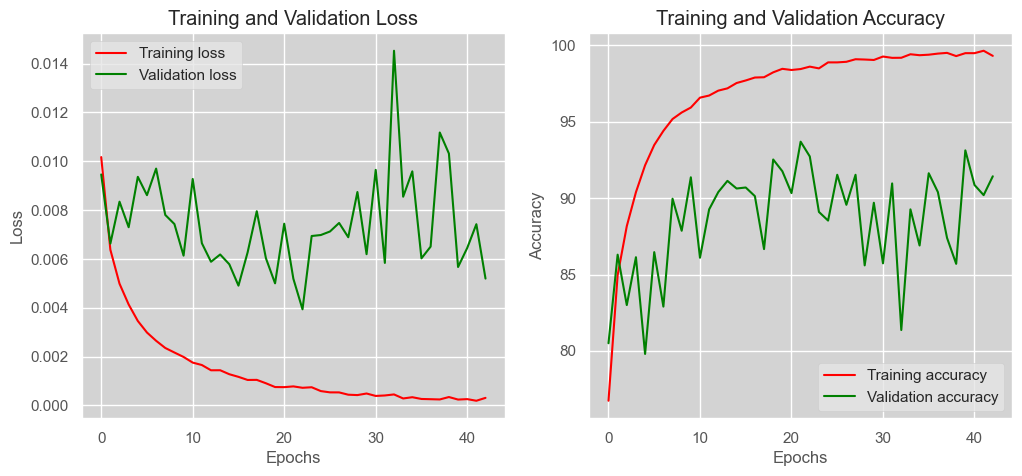

[[ 147   10    7    0  122   76]
 [   0  937    0    0   38    3]
 [   0    0  187    0    0   39]
 [   2    0   22  200    0    1]
 [  28   11   17    2  314   65]
 [ 130  148   13    0    2 1062]]


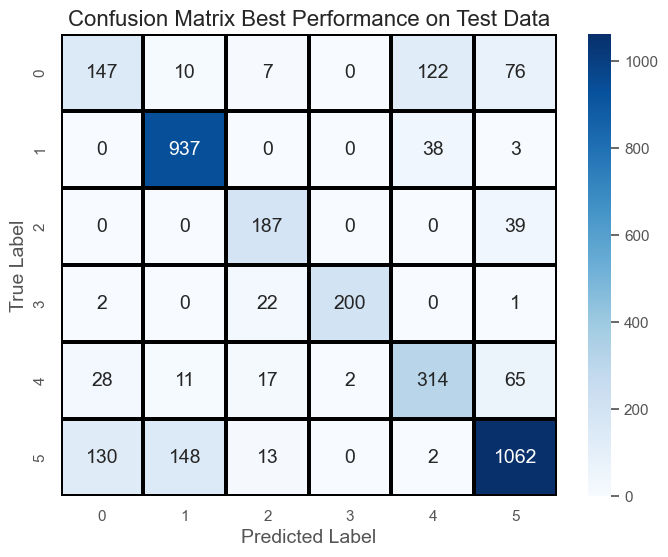

              precision    recall  f1-score   support

           0       0.48      0.41      0.44       362
           1       0.85      0.96      0.90       978
           2       0.76      0.83      0.79       226
           3       0.99      0.89      0.94       225
           4       0.66      0.72      0.69       437
           5       0.85      0.78      0.82      1355

    accuracy                           0.79      3583
   macro avg       0.76      0.76      0.76      3583
weighted avg       0.79      0.79      0.79      3583



In [159]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4_shifted[-1])
print('Loss on dev set: ', val_losses_cnn_config4_shifted[-1])

plot_performance(train_losses_cnn_config4_shifted, val_losses_cnn_config4_shifted, train_accs_cnn_config4_shifted, val_accs_cnn_config4_shifted)

def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Best Performance on Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4_shifted.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

###  3.1.d Jittering Dataset

In [145]:
def apply_jittering(data, jitter_strength=0.05):
    """
    Applies jittering to the dataset by adding small random values to each feature.
    
    :param data: A numpy array or a pandas dataframe with shape (n_samples, n_features).
    :param jitter_strength: A float representing the amount of noise to add (relative to the data range).
    
    :return: The augmented dataset with jitter applied.
    """
    # Calculate the jitter based on the data range and the specified jitter strength
    jitter = jitter_strength * (np.max(data, axis=0) - np.min(data, axis=0))
    
    # Add the jitter to the original data
    jittered_data = data + np.random.normal(0, jitter, data.shape)
    
    return jittered_data

# Assuming 'dataset' is your numpy array or dataframe
# You can call the function like this:

x_train_jittered = apply_jittering(x_train)

# x_train_augmented = np.concatenate((x_train, x_train_jittered), axis=0)
# y_train_augmented = np.concatenate((y_train, y_train), axis=0)

# Convert your numpy arrays to PyTorch tensors
x_train_jittered_tensor = torch.tensor(x_train_jittered, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset_jittered = TensorDataset(x_train_jittered_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader_jittered = DataLoader(train_dataset_jittered, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [146]:
class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4_jittered = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4_jittered.to(device)

# Print model summary
print(model_cnn_config4_jittered)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4_jittered.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4_jittered = []
val_losses_cnn_config4_jittered = []
train_accs_cnn_config4_jittered = []
val_accs_cnn_config4_jittered = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4_jittered.append(train_loss)
    train_accs_cnn_config4_jittered.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4_jittered.append(test_loss)
    val_accs_cnn_config4_jittered.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4_jittered, device, train_loader_jittered, my_optimizer, epoch)
    if validate(model_cnn_config4_jittered, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.009964 	Accuracy: 77.22%
Validation: Average loss: 0.0134, Accuracy: 1900/3000 (63.33%)
Train Epoch: 2 	Loss: 0.006274 	Accuracy: 85.21%
Validation: Average loss: 0.0081, Accuracy: 2449/3000 (81.63%)
Train Epoch: 3 	Loss: 0.004910 	Accuracy: 88.71%
Validation: Average loss: 0.0084, Accuracy: 2461/3000 (82.03%)
Train Epoch: 4 	Loss: 0.003818 	Accuracy: 91.59%
Validation: Average loss: 0.0072, Accuracy: 2564/3000 (85.47%)
Train Epoch: 5 	Loss: 0.003189 	Accuracy: 93.44%
Validation: Average loss: 0.0071, Accuracy: 2570/3000 (85.67%)
Train Epoc

Accuracy on dev set:  91.0
Loss on dev set:  0.007187242465826916


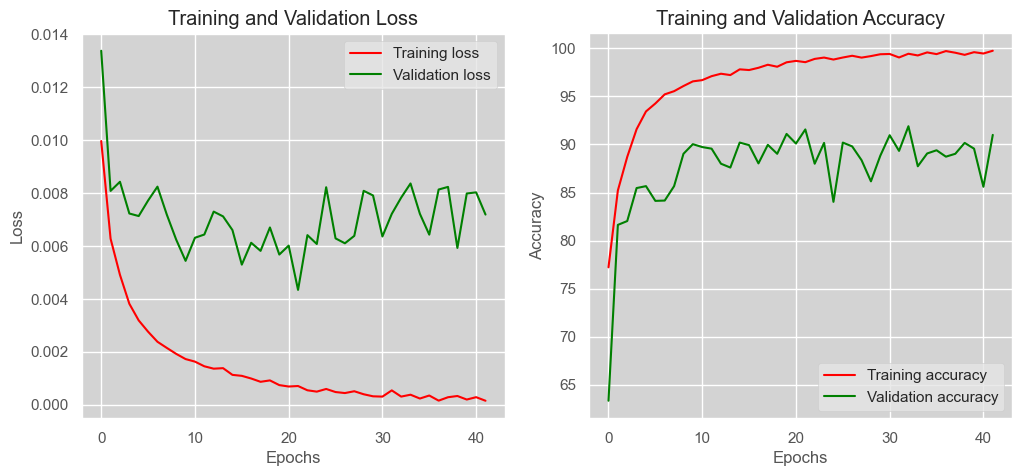

[[ 144   13    0    5   63  137]
 [   0  968    0    0    8    2]
 [   0    0  187   18    0   21]
 [   0    0   21  203    1    0]
 [  27   38    1   12  337   22]
 [   0  310    0    1    1 1043]]


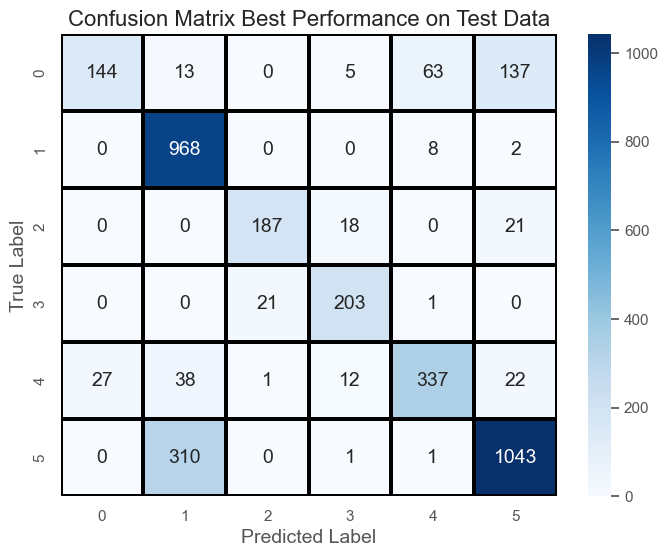

              precision    recall  f1-score   support

           0       0.84      0.40      0.54       362
           1       0.73      0.99      0.84       978
           2       0.89      0.83      0.86       226
           3       0.85      0.90      0.88       225
           4       0.82      0.77      0.80       437
           5       0.85      0.77      0.81      1355

    accuracy                           0.80      3583
   macro avg       0.83      0.78      0.79      3583
weighted avg       0.82      0.80      0.80      3583



In [158]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4_jittered[-1])
print('Loss on dev set: ', val_losses_cnn_config4_jittered[-1])

plot_performance(train_losses_cnn_config4_jittered, val_losses_cnn_config4_jittered, train_accs_cnn_config4_jittered, val_accs_cnn_config4_jittered)

def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Best Performance on Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4_jittered.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

## 3.2 Baseline Comparison

### 3.2.a  Random Baseline

In [149]:
import numpy as np

def random_baseline_predict(class_counts, num_predictions):
    """
    Returns a list of random predictions based on the class distribution.
    
    Parameters:
        class_counts (dict): A dictionary with class labels as keys and their counts as values.
        num_predictions (int): The number of random predictions to generate.
    
    Returns:
        list: A list of random predictions.
    """
    # Convert the class_counts dictionary to two lists for labels and their corresponding probabilities
    labels, counts = zip(*class_counts.items())
    total_count = sum(counts)
    probabilities = [count / total_count for count in counts]
    
    # Use np.random.choice to generate random predictions based on the probabilities
    predictions = np.random.choice(labels, size=num_predictions, p=probabilities)
    
    return predictions

# Example usage:
class_counts = df.activity.value_counts().to_dict()

num_predictions = 200  # Number of random predictions you want to generate
random_predictions = random_baseline_predict(class_counts, num_predictions)
print(random_predictions)

['Downstairs' 'Jogging' 'Jogging' 'Walking' 'Jogging' 'Upstairs' 'Walking'
 'Jogging' 'Walking' 'Walking' 'Upstairs' 'Walking' 'Downstairs' 'Walking'
 'Walking' 'Walking' 'Sitting' 'Upstairs' 'Walking' 'Standing' 'Walking'
 'Walking' 'Upstairs' 'Jogging' 'Jogging' 'Standing' 'Jogging' 'Walking'
 'Walking' 'Downstairs' 'Downstairs' 'Walking' 'Jogging' 'Upstairs'
 'Walking' 'Jogging' 'Walking' 'Jogging' 'Walking' 'Jogging' 'Sitting'
 'Upstairs' 'Sitting' 'Walking' 'Downstairs' 'Walking' 'Walking' 'Jogging'
 'Jogging' 'Walking' 'Downstairs' 'Walking' 'Jogging' 'Upstairs' 'Walking'
 'Jogging' 'Jogging' 'Jogging' 'Jogging' 'Upstairs' 'Sitting' 'Walking'
 'Walking' 'Jogging' 'Sitting' 'Jogging' 'Jogging' 'Walking' 'Walking'
 'Jogging' 'Sitting' 'Walking' 'Walking' 'Jogging' 'Walking' 'Downstairs'
 'Standing' 'Downstairs' 'Jogging' 'Walking' 'Jogging' 'Walking'
 'Downstairs' 'Walking' 'Jogging' 'Standing' 'Jogging' 'Jogging'
 'Standing' 'Jogging' 'Walking' 'Upstairs' 'Jogging' 'Walking' 'Walk

In [150]:
def calculate_accuracy(true_labels, predictions):
    correct_predictions = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

true_labels = df.activity.values
num_predictions = len(true_labels)  # Number of predictions should match the number of true labels
random_predictions = random_baseline_predict(class_counts, num_predictions)

random_baseline_accuracy = calculate_accuracy(true_labels, random_predictions)
print(f"Random Baseline Accuracy: {random_baseline_accuracy * 100:.2f}%")

Random Baseline Accuracy: 27.21%


### 3.2.c 500 Epochs

In [153]:
# Create DataLoaders
batch_size = 512  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4 = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4.to(device)

# Print model summary
print(model_cnn_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4 = []
val_losses_cnn_config4 = []
train_accs_cnn_config4 = []
val_accs_cnn_config4 = []

best_val_loss = float('inf')
patience = 500
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4.append(train_loss)
    train_accs_cnn_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4.append(test_loss)
    val_accs_cnn_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.001947 	Accuracy: 66.08%
Validation: Average loss: 0.0014, Accuracy: 2204/3000 (73.47%)
Train Epoch: 2 	Loss: 0.001161 	Accuracy: 78.75%
Validation: Average loss: 0.0011, Accuracy: 2452/3000 (81.73%)
Train Epoch: 3 	Loss: 0.000917 	Accuracy: 83.08%
Validation: Average loss: 0.0010, Accuracy: 2508/3000 (83.60%)
Train Epoch: 4 	Loss: 0.000801 	Accuracy: 84.86%
Validation: Average loss: 0.0013, Accuracy: 2367/3000 (78.90%)
Train Epoch: 5 	Loss: 0.000712 	Accuracy: 86.54%
Validation: Average loss: 0.0010, Accuracy: 2508/3000 (83.60%)
Train Epoc

Accuracy on dev set:  90.23333333333333
Loss on dev set:  0.001898309225216508


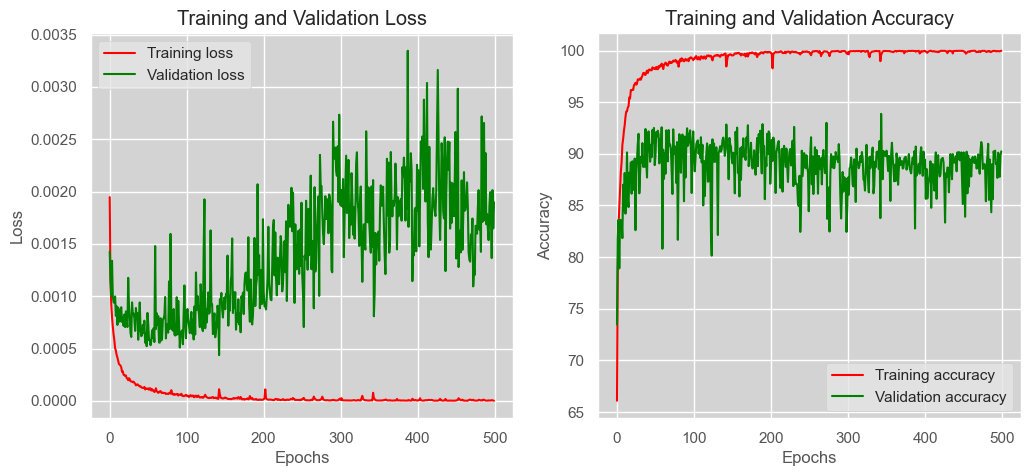

In [154]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4[-1])
print('Loss on dev set: ', val_losses_cnn_config4[-1])

plot_performance(train_losses_cnn_config4, val_losses_cnn_config4, train_accs_cnn_config4, val_accs_cnn_config4)

In [157]:
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.86      0.54      0.67       362
           1       0.71      1.00      0.83       978
           2       0.96      0.83      0.89       226
           3       1.00      0.92      0.96       225
           4       0.81      0.64      0.72       437
           5       0.84      0.77      0.80      1355

    accuracy                           0.81      3583
   macro avg       0.87      0.78      0.81      3583
weighted avg       0.82      0.81      0.80      3583



### 3.3: Batch Normalization and Layer Normalization

In [180]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration4_Norm(nn.Module):

    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4_Norm, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.bn1 = nn.BatchNorm1d(200)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.bn2 = nn.BatchNorm1d(120)  # Batch Normalization after Conv2
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.bn3 = nn.BatchNorm1d(160)  # Batch Normalization after Conv2
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)
        self.ln = nn.LayerNorm(160)  # Layer Normalization before the fully connected layer

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.avgpool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.ln(x)  # Apply Layer Normalization
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4_normalized = MyConvModel_Configuration4_Norm(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4_normalized.to(device)

# Print model summary
print(model_cnn_config4_normalized)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4_normalized.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4_normalized = []
val_losses_cnn_config4_normalized = []
train_accs_cnn_config4_normalized = []
val_accs_cnn_config4_normalized = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4_normalized.append(train_loss)
    train_accs_cnn_config4_normalized.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4_normalized.append(test_loss)
    val_accs_cnn_config4_normalized.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4_normalized, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4_normalized, device, test_loader):
        break

MyConvModel_Configuration4_Norm(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (bn2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (bn3): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
  (ln): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
)
Train Epoch: 1 	Loss: 0.006221 	Accuracy: 86.67%
Validation: Average loss: 0.0087, Accuracy: 2738/3000 (91.27%)
Train Epoch: 2 	Loss: 0.002976 	Accuracy: 94.34%
Validation: Average loss: 0.0117, Accuracy: 2652/3000 (88.40%)
Train Epo

Accuracy on dev set:  86.6
Loss on dev set:  0.012109824275687558


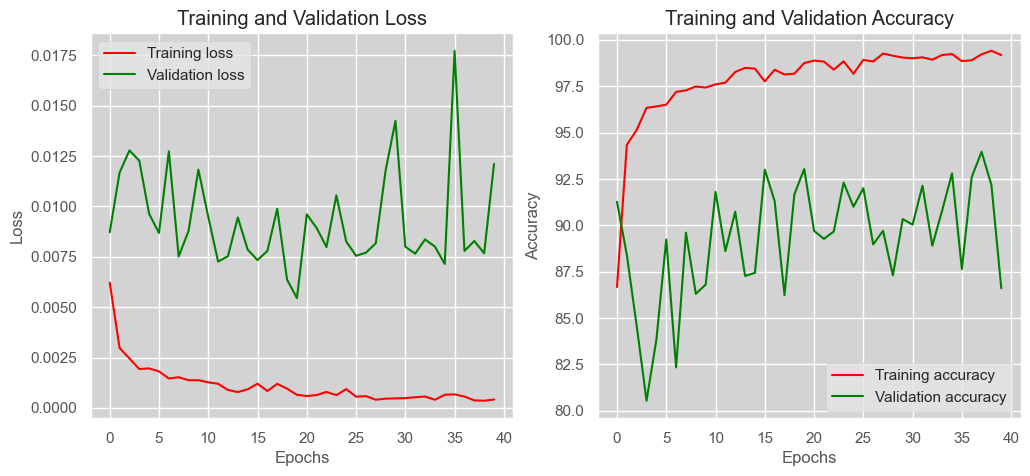

In [181]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4_normalized[-1])
print('Loss on dev set: ', val_losses_cnn_config4_normalized[-1])

plot_performance(train_losses_cnn_config4_normalized, val_losses_cnn_config4_normalized, train_accs_cnn_config4_normalized, val_accs_cnn_config4_normalized)

### 3.4: Adam with Learning Rate = 0.1

In [201]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4 = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4.to(device)

# Print model summary
print(model_cnn_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.AdamW(model_cnn_config4.parameters(), lr=0.001)


EPOCHS = 500

train_losses_cnn_config4 = []
val_losses_cnn_config4 = []
train_accs_cnn_config4 = []
val_accs_cnn_config4 = []

best_val_loss = float('inf')
patience = 10
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4.append(train_loss)
    train_accs_cnn_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4.append(test_loss)
    val_accs_cnn_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.009698 	Accuracy: 77.65%
Validation: Average loss: 0.0074, Accuracy: 2575/3000 (85.83%)
Train Epoch: 2 	Loss: 0.005343 	Accuracy: 87.50%
Validation: Average loss: 0.0074, Accuracy: 2436/3000 (81.20%)
Train Epoch: 3 	Loss: 0.003853 	Accuracy: 91.46%
Validation: Average loss: 0.0068, Accuracy: 2551/3000 (85.03%)
Train Epoch: 4 	Loss: 0.003018 	Accuracy: 93.69%
Validation: Average loss: 0.0067, Accuracy: 2614/3000 (87.13%)
Train Epoch: 5 	Loss: 0.002643 	Accuracy: 94.90%
Validation: Average loss: 0.0052, Accuracy: 2742/3000 (91.40%)
Train Epoc

Accuracy on dev set:  93.06666666666666
Loss on dev set:  0.0056583631221507604


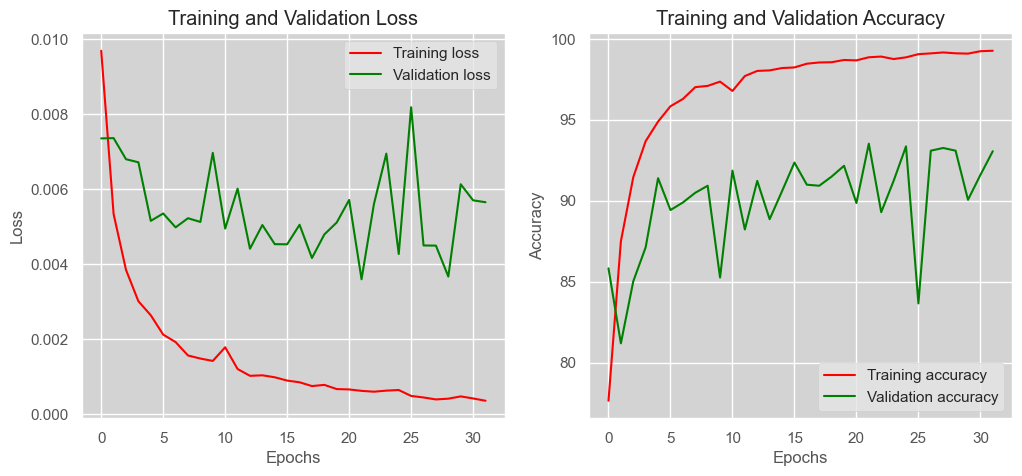

In [202]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4[-1])
print('Loss on dev set: ', val_losses_cnn_config4[-1])

plot_performance(train_losses_cnn_config4, val_losses_cnn_config4, train_accs_cnn_config4, val_accs_cnn_config4)

### 3.5.a Scalling Down

In [203]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN_Scaled_Down(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN_Scaled_Down, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 50, kernel_size=10)
        self.conv2 = nn.Conv1d(50, 50, kernel_size=10)
        self.conv3 = nn.Conv1d(50, 80, kernel_size=10)
        self.conv4 = nn.Conv1d(80, 80, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(80, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 80)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_sd = CNN_Scaled_Down(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_sd.to(device)

# Print model summary
print(model_cnn_sd)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_sd.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses_sd = []
val_losses_sd = []
train_accs_sd = []
val_accs_sd = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_sd.append(train_loss)
    train_accs_sd.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_sd.append(test_loss)
    val_accs_sd.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_sd, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_sd, device, test_loader):
        break

CNN_Scaled_Down(
  (conv1): Conv1d(3, 50, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(50, 50, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(50, 80, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(80, 80, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=80, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002705 	Accuracy: 60.34%
Validation: Average loss: 0.0024, Accuracy: 2177/3000 (72.57%)
Train Epoch: 2 	Loss: 0.001675 	Accuracy: 75.13%
Validation: Average loss: 0.0022, Accuracy: 2150/3000 (71.67%)
Train Epoch: 3 	Loss: 0.001283 	Accuracy: 77.99%
Validation: Average loss: 0.0018, Accuracy: 2211/3000 (73.70%)
Train Epoch: 4 	Loss: 0.001000 	Accuracy: 84.13%
Validation: Average loss: 0.0018, Accuracy: 2402/3000 (80.07%)
Train Epoch: 5 	Loss: 0.000867 	Accuracy: 86.70%
Validation: 

Accuracy on dev set:  87.4
Loss on dev set:  0.0017515484636339048


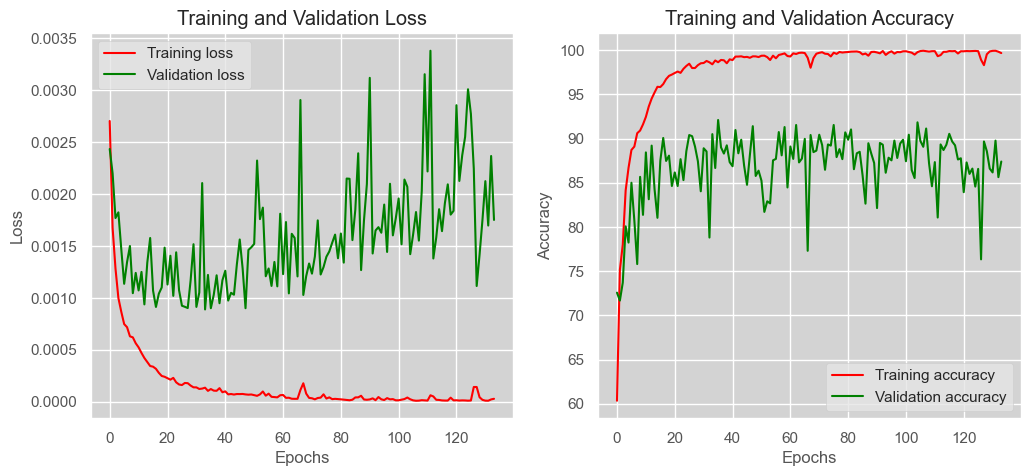

In [204]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_sd[-1])
print('Loss on dev set: ', val_losses_sd[-1])

plot_performance(train_losses_sd, val_losses_sd, train_accs_sd, val_accs_sd)

### 3.5.b Reducing the Dropout

In [205]:
# Create DataLoaders
batch_size = 400  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.002216 	Accuracy: 67.19%
Validation: Average loss: 0.0020, Accuracy: 2200/3000 (73.33%)
Train Epoch: 2 	Loss: 0.001167 	Accuracy: 83.18%
Validation: Average loss: 0.0021, Accuracy: 2265/3000 (75.50%)
Train Epoch: 3 	Loss: 0.000854 	Accuracy: 87.78%
Validation: Average loss: 0.0019, Accuracy: 2172/3000 (72.40%)
Train Epoch: 4 	Loss: 0.000641 	Accuracy: 90.51%
Validation: Average loss: 0.0014, Accuracy: 2546/3000 (84.87%)
Train Epoch: 5 	Loss: 0.000507 	Accuracy: 92.33%
Validation: Aver

Accuracy on dev set:  90.0
Loss on dev set:  0.0017515484636339048


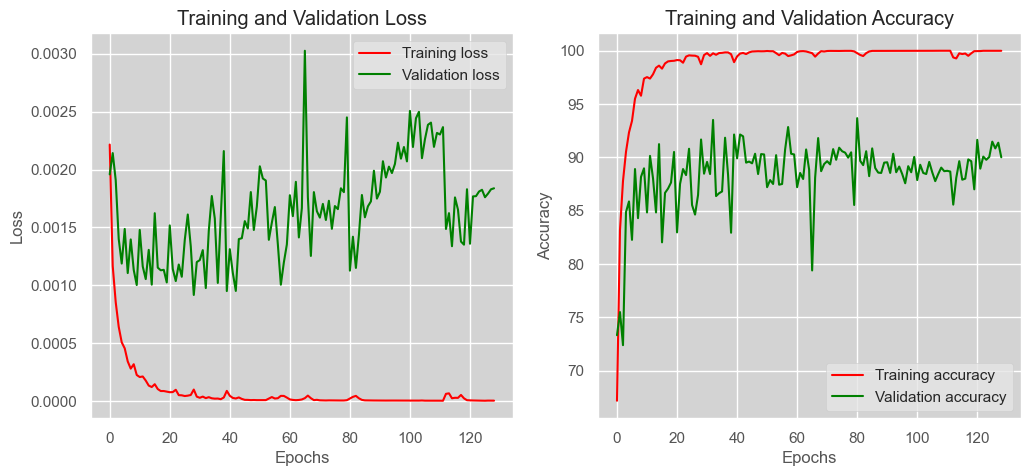

In [206]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs[-1])
print('Loss on dev set: ', val_losses_sd[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### Removing Dropout

In [207]:
# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(CNN, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=10)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=10)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=10)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=10)
        self.maxpool = nn.MaxPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = CNN(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

BATCH_SIZE = 64
EPOCHS = 500

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
patience = 100
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(test_loss)
    val_accs.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn, device, test_loader):
        break

CNN(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(10,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.007663 	Accuracy: 81.07%
Validation: Average loss: 0.0120, Accuracy: 1940/3000 (64.67%)
Train Epoch: 2 	Loss: 0.003045 	Accuracy: 92.63%
Validation: Average loss: 0.0056, Accuracy: 2612/3000 (87.07%)
Train Epoch: 3 	Loss: 0.001815 	Accuracy: 96.02%
Validation: Average loss: 0.0052, Accuracy: 2726/3000 (90.87%)
Train Epoch: 4 	Loss: 0.001223 	Accuracy: 97.60%
Validation: Average loss: 0.0049, Accuracy: 2704/3000 (90.13%)
Train Epoch: 5 	Loss: 0.001045 	Accuracy: 97.85%
Validation: Average loss: 0.0108, Accuracy: 2351/3000 (78.3

Accuracy on dev set:  87.53333333333333
Loss on dev set:  0.0017515484636339048


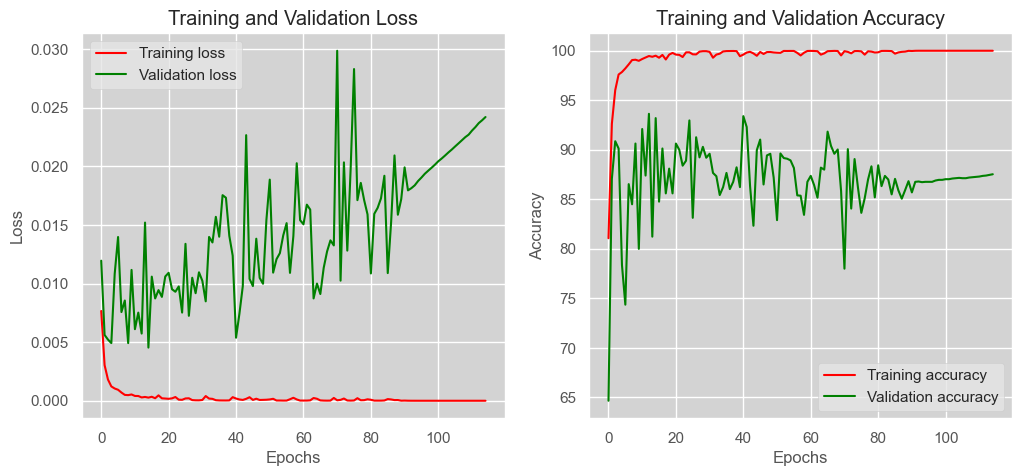

In [208]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs[-1])
print('Loss on dev set: ', val_losses_sd[-1])

plot_performance(train_losses, val_losses, train_accs, val_accs)

### 3.5.d Down Sampling 10Hz

In [224]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([32, 31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80 // 2  # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40 // 2  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train.iloc[::2, :],
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


# Create DataLoaders
batch_size = 200  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=5)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=5)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=5)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=5)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x = x.view(-1, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with softmax activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_base = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_base.to(device)

# Print model summary
print(model_cnn_base)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_base.parameters(), lr=0.001)

EPOCHS = 500

train_losses_base = []
val_losses_base = []
train_accs_base = []
val_accs_base = []



best_val_loss = float('inf')
patience = 100
trigger_times = 0


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_base.append(train_loss)
    train_accs_base.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_base.append(test_loss)
    val_accs_base.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_base, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_base, device, test_loader):
        break



MyConvModel(
  (conv1): Conv1d(3, 100, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.004020 	Accuracy: 69.52%
Validation: Average loss: 0.0057, Accuracy: 3546/6001 (59.09%)
Train Epoch: 2 	Loss: 0.001850 	Accuracy: 86.37%
Validation: Average loss: 0.0091, Accuracy: 2337/6001 (38.94%)
Train Epoch: 3 	Loss: 0.001380 	Accuracy: 89.44%
Validation: Average loss: 0.0108, Accuracy: 2602/6001 (43.36%)
Train Epoch: 4 	Loss: 0.001077 	Accuracy: 92.03%
Validation: Average loss: 0.0142, Accuracy: 2326/6001 (38.76%)
Train Epoch: 5 	Loss: 0.000885 	Accuracy: 93.83%
Validation: Av

Accuracy on dev set:  50.558240293284456
Loss on dev set:  0.02745708188811344


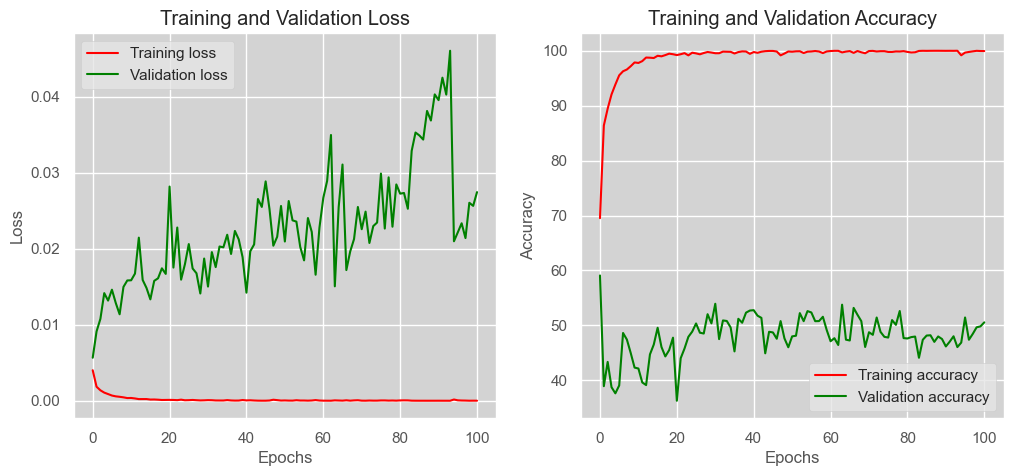

In [225]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_base[-1])
print('Loss on dev set: ', val_losses_base[-1])

plot_performance(train_losses_base, val_losses_base, train_accs_base, val_accs_base)

### 4Hz

In [233]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80 // 5  # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40 // 5  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train.iloc[::5, :],
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 1D Convolutional Neural Network
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes

        # Convolutional layers
        self.conv1 = nn.Conv1d(n_sensors, 100, kernel_size=2)
        self.conv2 = nn.Conv1d(100, 100, kernel_size=2)
        self.conv3 = nn.Conv1d(100, 160, kernel_size=2)
        self.conv4 = nn.Conv1d(160, 160, kernel_size=2)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x = x.view(-1, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Global average pooling and dropout
        x = self.adaptive_pool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with softmax activation
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_base = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_base.to(device)

# Print model summary
print(model_cnn_base)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_base.parameters(), lr=0.001)

EPOCHS = 500

train_losses_base = []
val_losses_base = []
train_accs_base = []
val_accs_base = []



best_val_loss = float('inf')
patience = 100
trigger_times = 0


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_base.append(train_loss)
    train_accs_base.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_base.append(test_loss)
    val_accs_base.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_base, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_base, device, test_loader):
        break

MyConvModel(
  (conv1): Conv1d(3, 100, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(100, 160, kernel_size=(2,), stride=(1,))
  (conv4): Conv1d(160, 160, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.012138 	Accuracy: 72.24%
Validation: Average loss: 0.0153, Accuracy: 8885/15005 (59.21%)
Train Epoch: 2 	Loss: 0.008058 	Accuracy: 81.02%
Validation: Average loss: 0.0213, Accuracy: 7418/15005 (49.44%)
Train Epoch: 3 	Loss: 0.006828 	Accuracy: 83.61%
Validation: Average loss: 0.0182, Accuracy: 8421/15005 (56.12%)
Train Epoch: 4 	Loss: 0.006350 	Accuracy: 84.59%
Validation: Average loss: 0.0257, Accuracy: 7200/15005 (47.98%)
Train Epoch: 5 	Loss: 0.005617 	Accuracy: 86.65%
Validation:

Accuracy on dev set:  46.184605131622796
Loss on dev set:  0.11860444705592796


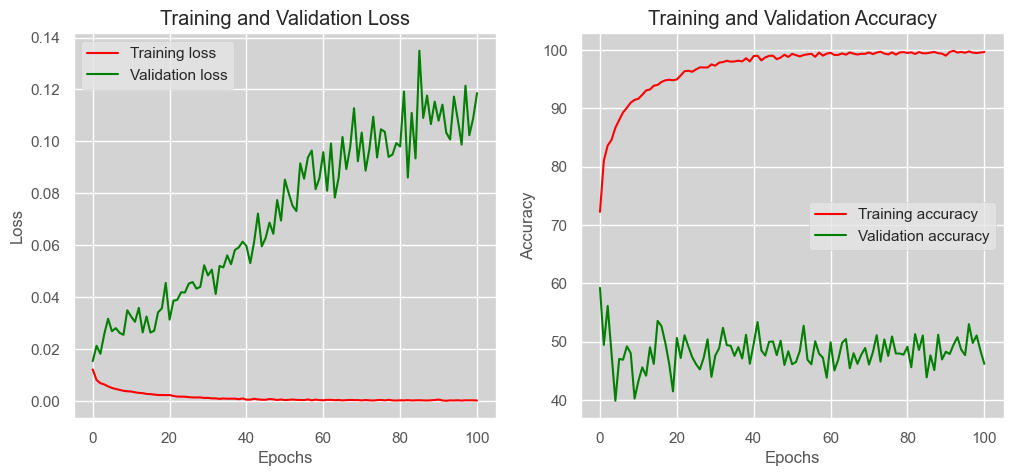

In [234]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_base[-1])
print('Loss on dev set: ', val_losses_base[-1])

plot_performance(train_losses_base, val_losses_base, train_accs_base, val_accs_base)

### 3.6.a Random Sampling

In [247]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

# Split data into train and test set
# train/validation: user 1 ~ 28
# test: user 28 ~

from sklearn.model_selection import train_test_split

df_train = df[df['user'] <= 28]
df_validate = df[df['user'].isin([32,31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df[df['user'] > 32]

# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

print('x_train shape:', x_train.shape)
print('x_validate shape:', x_validate.shape)
print('x_test shape:', x_test.shape)
print('input shape:', input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4 = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4.to(device)

# Print model summary
print(model_cnn_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4 = []
val_losses_cnn_config4 = []
train_accs_cnn_config4 = []
val_accs_cnn_config4 = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4.append(train_loss)
    train_accs_cnn_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4.append(test_loss)
    val_accs_cnn_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4, device, test_loader):
        break



x_train shape: (20868, 240)
x_validate shape: (3583, 240)
x_test shape: (3000, 240)
input shape: 240
New y_train shape:  torch.Size([20868, 6])
MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.021462 	Accuracy: 48.48%
Validation: Average loss: 0.0181, Accuracy: 1659/3000 (55.30%)
Train Epoch: 2 	Loss: 0.014449 	Accuracy: 70.88%
Validation: Average loss: 0.0124, Accuracy: 2113/3000 (70.43%)
Train Epoch: 3 	Loss: 0.011283 	Accuracy: 75.31%
Validation: Average loss: 0.0120, Accuracy: 2191/3000 (73.03%)
Train Epoch: 4 	Loss: 0.010394 	Accuracy: 77.59%
Validation: Average loss: 0.0093, Accurac

Accuracy on dev set:  88.7
Loss on dev set:  0.007721815628734523


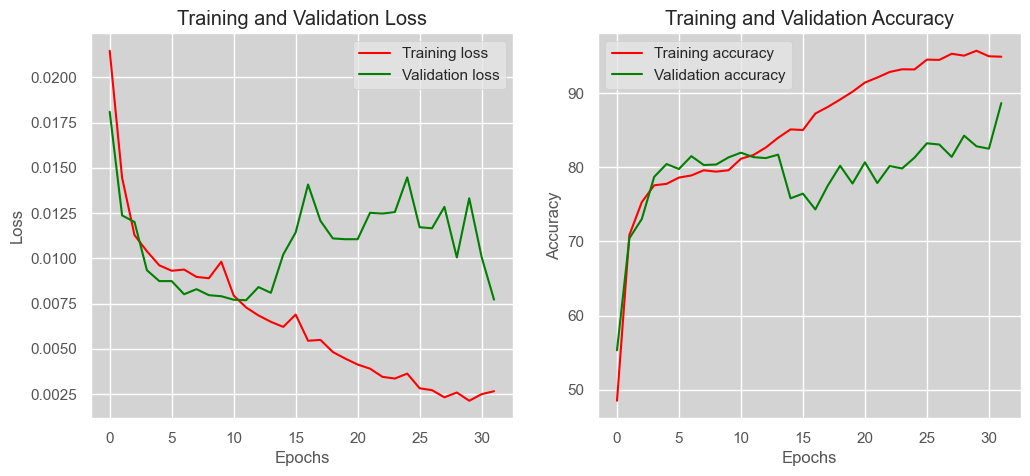

In [248]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4[-1])
print('Loss on dev set: ', val_losses_cnn_config4[-1])

plot_performance(train_losses_cnn_config4, val_losses_cnn_config4, train_accs_cnn_config4, val_accs_cnn_config4)

[[  53   32    0    1   75  201]
 [   0  957    0    0   20    1]
 [   0    0  187    0   39    0]
 [   1    0   18  181   25    0]
 [  28   68    0    2  174  165]
 [   0  313    0    0    3 1039]]


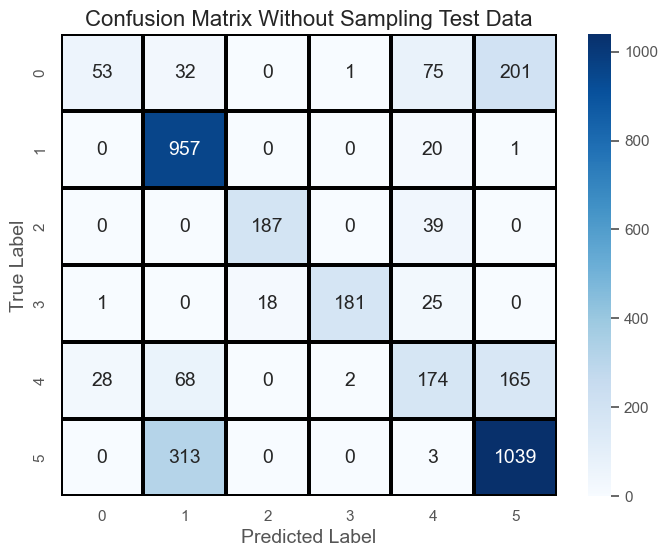

              precision    recall  f1-score   support

           0       0.65      0.15      0.24       362
           1       0.70      0.98      0.82       978
           2       0.91      0.83      0.87       226
           3       0.98      0.80      0.89       225
           4       0.52      0.40      0.45       437
           5       0.74      0.77      0.75      1355

    accuracy                           0.72      3583
   macro avg       0.75      0.65      0.67      3583
weighted avg       0.72      0.72      0.70      3583



In [250]:
def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Without Sampling Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

### 3.6.b Over Sampling

In [255]:
print("Before Over Sampling:", df['activity'].value_counts())


from sklearn.utils import resample

# Assuming 'df' is your DataFrame containing the 'activity' column
activity_counts = df['activity'].value_counts()
max_count = activity_counts.max()

# Create a new DataFrame for the balanced dataset
df_balanced = pd.DataFrame()

for activity, count in activity_counts.items():
    df_activity = df[df['activity'] == activity]
    # Resample the minority classes
    df_activity_resampled = resample(df_activity, replace=True, n_samples=max_count, random_state=42)
    df_balanced = pd.concat([df_balanced, df_activity_resampled])

# Check the new class distribution
print("After Over Sampling:", df_balanced['activity'].value_counts())

LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df_balanced[LABEL] = le.fit_transform(df_balanced['activity'].values.ravel())

df_train = df_balanced[df_balanced['user'] <= 28]
df_validate = df_balanced[df_balanced['user'].isin([31,30,29])]   # selects a portion of the data from df_train for validation purposes 
df_test = df_balanced[df_balanced['user'] > 32]

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_validate['x-axis'] = df_validate['x-axis'] / df_validate['x-axis'].max()
df_validate['y-axis'] = df_validate['y-axis'] / df_validate['y-axis'].max()
df_validate['z-axis'] = df_validate['z-axis'] / df_validate['z-axis'].max()

df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_validate = df_validate.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y

# Define new time periods for downsampling
TIME_PERIODS = 80   # Adjust TIME_PERIODS for downsampling
STEP_DISTANCE = 40  # Adjust STEP_DISTANCE for downsampling

x_train, y_train = create_segments_and_labels(df_train,
                                                        TIME_PERIODS,  # Adjust TIME_PERIODS accordingly
                                                        STEP_DISTANCE,  # Adjust STEP_DISTANCE accordingly
                                                        LABEL)

x_validate, y_validate = create_segments_and_labels(df_validate,
                                                    TIME_PERIODS,
                                                    STEP_DISTANCE,
                                                    LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size

input_shape = (n_time_periods * n_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], input_shape)
x_test =  x_test.reshape(x_test.shape[0], input_shape)

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_validate = x_validate.astype('float32')
y_validate = y_validate.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_validate_tensor = torch.tensor(x_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validate_dataset = TensorDataset(x_validate_tensor, y_validate_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64  # You can change this value as per your need
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Before Over Sampling: activity
Walking       424399
Jogging       342179
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64
After Over Sampling: activity
Walking       424399
Jogging       424399
Upstairs      424399
Downstairs    424399
Sitting       424399
Standing      424399
Name: count, dtype: int64


In [256]:
class MyConvModel_Configuration4(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes):
        super(MyConvModel_Configuration4, self).__init__()
        self.n_sensors = n_sensors
        self.time_periods = time_periods
        self.n_classes = n_classes
        self.conv1 = nn.Conv1d(n_sensors, 200, kernel_size=10)
        self.conv2 = nn.Conv1d(200, 120, kernel_size=10)
        self.conv3 = nn.Conv1d(120, 160, kernel_size=10)
        self.avgpool = nn.AvgPool1d(3)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(160, n_classes)

    def forward(self, x):
        x = x.view(-1, self.n_sensors, self.time_periods)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = self.dropout(x)
        x = x.view(-1, 160)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def predict(self, x):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn_config4 = MyConvModel_Configuration4(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn_config4.to(device)

# Print model summary
print(model_cnn_config4)

# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

# Choose your Optimizer
my_optimizer = optim.Adam(model_cnn_config4.parameters(), lr=0.001)

EPOCHS = 500

train_losses_cnn_config4 = []
val_losses_cnn_config4 = []
train_accs_cnn_config4 = []
val_accs_cnn_config4 = []

best_val_loss = float('inf')
patience = 20
trigger_times = 0

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses_cnn_config4.append(train_loss)
    train_accs_cnn_config4.append(accuracy)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')

def validate(model, device, test_loader):
    global best_val_loss, trigger_times
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses_cnn_config4.append(test_loss)
    val_accs_cnn_config4.append(accuracy)
    print(f'Validation: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            return True
    return False

for epoch in range(1, EPOCHS + 1):
    train(model_cnn_config4, device, train_loader, my_optimizer, epoch)
    if validate(model_cnn_config4, device, test_loader):
        break

MyConvModel_Configuration4(
  (conv1): Conv1d(3, 200, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(200, 120, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(120, 160, kernel_size=(10,), stride=(1,))
  (avgpool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=160, out_features=6, bias=True)
)
Train Epoch: 1 	Loss: 0.006452 	Accuracy: 82.00%
Validation: Average loss: 0.0386, Accuracy: 3340/7408 (45.09%)
Train Epoch: 2 	Loss: 0.004590 	Accuracy: 87.74%
Validation: Average loss: 0.0216, Accuracy: 4290/7408 (57.91%)
Train Epoch: 3 	Loss: 0.003821 	Accuracy: 90.08%
Validation: Average loss: 0.0260, Accuracy: 4622/7408 (62.39%)
Train Epoch: 4 	Loss: 0.003347 	Accuracy: 91.41%
Validation: Average loss: 0.0251, Accuracy: 5001/7408 (67.51%)
Train Epoch: 5 	Loss: 0.002908 	Accuracy: 92.72%
Validation: Average loss: 0.0298, Accuracy: 4791/7408 (64.67%)
Train Epoc

Accuracy on dev set:  62.621490280777536
Loss on dev set:  0.06074075650129543


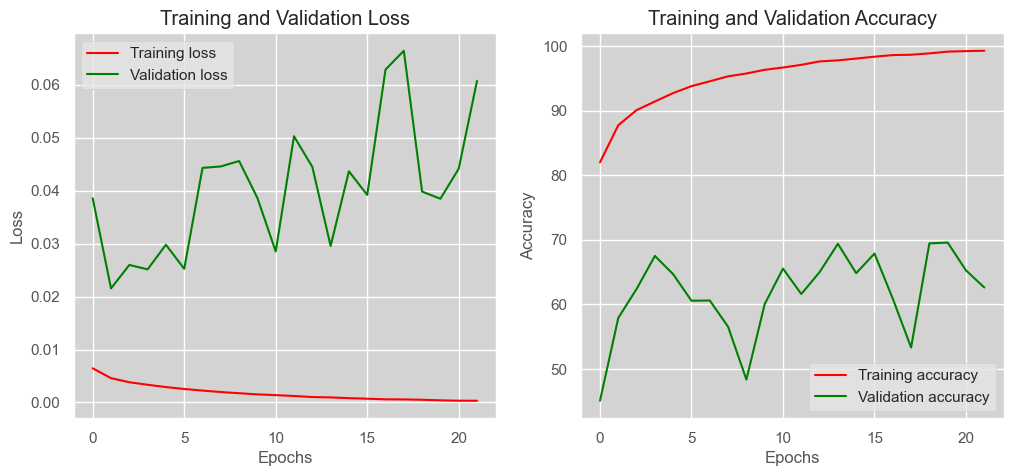

In [257]:
# Losses and accuracy plots
# Losses and accuracy plots
def plot_performance(train_losses, val_losses, train_accs, val_accs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss', color='red')
    plt.plot(val_losses, label='Validation loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training accuracy', color='red')
    plt.plot(val_accs, label='Validation accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_facecolor('lightgray')

    plt.show()
    
print('Accuracy on dev set: ', val_accs_cnn_config4[-1])
print('Loss on dev set: ', val_losses_cnn_config4[-1])

plot_performance(train_losses_cnn_config4, val_losses_cnn_config4, train_accs_cnn_config4, val_accs_cnn_config4)

[[  23   10    1    0  345  899]
 [   0  790    0    0    0   45]
 [   0    1 1075    0    0    0]
 [   0    0    0    3 1593    0]
 [   3   96    0    0 1009   77]
 [  31  574    0    0  213  225]]


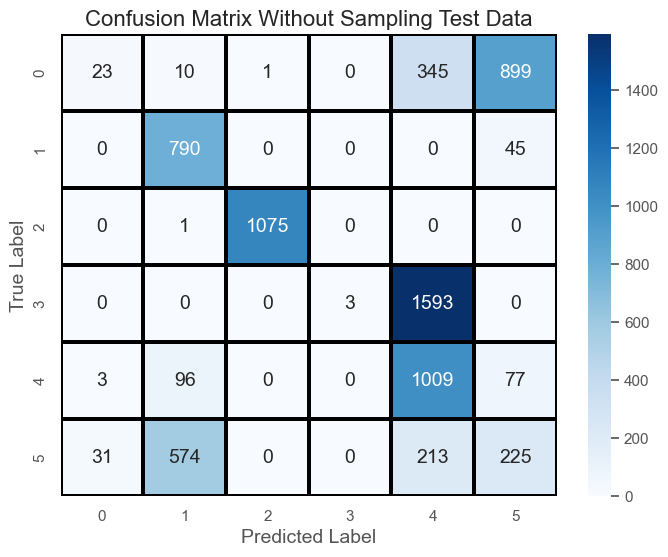

              precision    recall  f1-score   support

           0       0.40      0.02      0.03      1278
           1       0.54      0.95      0.69       835
           2       1.00      1.00      1.00      1076
           3       1.00      0.00      0.00      1596
           4       0.32      0.85      0.46      1185
           5       0.18      0.22      0.20      1043

    accuracy                           0.45      7013
   macro avg       0.57      0.51      0.40      7013
weighted avg       0.60      0.45      0.35      7013



In [258]:
def show_confusion_matrix(validations, predictions, title=None, labels=None):
    matrix = metrics.confusion_matrix(validations, predictions)
    print(matrix)
    
    plt.figure(figsize=(8, 6))  # Increase the figure size
    sns.heatmap(matrix,
                cmap='Blues',  # Change the color map to blues
                linecolor='black',  # Change the line color to black
                linewidths=1.5,  # Increase the line width
                xticklabels=labels if labels is not None else True,
                yticklabels=labels if labels is not None else True,
                annot=True,
                fmt='d',
                annot_kws={"size": 14})  # Increase the font size of annotations
    if title:
        plt.title(title, fontsize=16)  # Increase the title font size
    else:
        plt.title('Confusion Matrix Without Sampling Test Data', fontsize=16)
    plt.ylabel('True Label', fontsize=14)  # Increase the font size of y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # Increase the font size of x-axis label
    plt.show()

# Get the predictions and true labels
all_predictions = []
all_labels = []
for data, labels in validate_loader:
    data = data.to(device)
    predictions = model_cnn_config4.predict(data)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

show_confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))